<a href="https://www.kaggle.com/code/dheerajkr1a1a/arrclean-tomato-climate-prophet?scriptVersionId=138138327" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

<a href="https://colab.research.google.com/github/dheerajkumar1a1a/Kaggle_github/blob/main/arrclean_adf_tomato_Ranchi_prophet_multiv_rain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Objective
The goal is to utilize the prophet multivariate time series model to forecast the spot prices of tomatoes at the Ranchi center, incorporating both macroeconomic and climate-related variables.

# Data Collection
We can acces the data from Kaggle using   [Link for dataset](https://www.kaggle.com/datasets/dheerajkr1a1a/tomtao-prices-a-q)


# Importing Libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import cufflinks as cf
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default='plotly_white'
import os
# import plotly.io as pio
# pio.renderers.default = 'colab'
import seaborn as sns
import plotly.express as px
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, r2_score,mean_absolute_percentage_error
from sklearn.model_selection import train_test_split
from prophet.plot import plot_cross_validation_metric
from prophet.diagnostics import performance_metrics
from prophet.diagnostics import cross_validation
#from sklearn.linear_model import LinearRegression
from plotly.subplots import make_subplots
import itertools
%matplotlib inline
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)
cf.go_offline()

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning:

A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5



# Reading & plotting complete data for Ranchi center

In [2]:
parent_df={}
parent_df['RANCHI']=pd.read_csv('/kaggle/input/tomtao-prices-a-q/multi/complete_data.csv',index_col=0,parse_dates=[0])

In [3]:
# import plotly.io as pio
# pio.renderers.default = 'colab'

In [4]:
# sns.lineplot(data=parent_df['RANCHI'])
parent_df['RANCHI'].iplot()

# Plotting only Retail Prices & Arrival Quantity

In [5]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Retail Prices','Arrival Quantity'])

# Plotting Arrival Quantity

In [6]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Arrival Quantity'])

# Dropping the outliers with arrival qty less than threshold set for keeping the data
**For example here 300 is the threshold and two values are 220 and 160 being the local outliers will not be dropped.**

In [7]:
parent_df['RANCHI'].drop(['2010-02-18','2012-06-27','2014-05-30'],inplace=True)

In [8]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7468 entries, 2002-01-01 to 2023-06-30
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  4954 non-null   float64
 1   Retail Prices     4954 non-null   float64
 2   Min Price         4954 non-null   float64
 3   Max Price         4954 non-null   float64
 4   Modal Price       4954 non-null   float64
dtypes: float64(5)
memory usage: 350.1 KB


# Looking for the changes

In [9]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Arrival Quantity'])

# Checking data from 2010 onwards

In [10]:
parent_df['RANCHI'].loc['2010':'2019','Arrival Quantity'].isnull().sum()

854

# Filling null with -1 to prevent them from being lost when applying condition of dropping outliers

In [11]:
parent_df['RANCHI']['Arrival Quantity'].fillna(-1,inplace=True)

In [12]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7468 entries, 2002-01-01 to 2023-06-30
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  7468 non-null   float64
 1   Retail Prices     4954 non-null   float64
 2   Min Price         4954 non-null   float64
 3   Max Price         4954 non-null   float64
 4   Modal Price       4954 non-null   float64
dtypes: float64(5)
memory usage: 608.1 KB


# Condition of dropping outliers

In [13]:
parent_df['RANCHI']=parent_df['RANCHI'][parent_df['RANCHI']['Arrival Quantity']<=300]

In [14]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7466 entries, 2002-01-01 to 2023-06-30
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  7466 non-null   float64
 1   Retail Prices     4952 non-null   float64
 2   Min Price         4952 non-null   float64
 3   Max Price         4952 non-null   float64
 4   Modal Price       4952 non-null   float64
dtypes: float64(5)
memory usage: 350.0 KB


# Arrival qty without outliers

In [15]:
px.line(parent_df['RANCHI'],x=parent_df['RANCHI'].index,y=['Arrival Quantity'])

# Getting back the null values for easier analysis

In [16]:
parent_df['RANCHI']['Arrival Quantity'].replace(-1,np.nan,inplace=True)

In [17]:
parent_df['RANCHI'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7466 entries, 2002-01-01 to 2023-06-30
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Arrival Quantity  4952 non-null   float64
 1   Retail Prices     4952 non-null   float64
 2   Min Price         4952 non-null   float64
 3   Max Price         4952 non-null   float64
 4   Modal Price       4952 non-null   float64
dtypes: float64(5)
memory usage: 350.0 KB


In [18]:
df_Ranchi=parent_df['RANCHI'].copy()

In [19]:
df_Ranchi['2011':'2012'].describe()

Arrival Quantity  Retail Prices    Min Price     Max Price  Modal Price
count        580.000000     580.000000   580.000000    580.000000   580.000000
mean          21.462069    1725.517241   772.468966   1044.360345   886.324138
std            8.741160     990.688378   358.291856    673.969941   401.884265
min            1.000000     500.000000   150.000000    245.000000   200.000000
25%           16.000000    1000.000000   400.000000    600.000000   500.000000
50%           22.000000    1600.000000   790.000000   1000.000000   900.000000
75%           28.000000    2400.000000  1100.000000   1400.000000  1200.000000
max           60.000000   18000.000000  2100.000000  13004.000000  2250.000000

# Visualising the data with outliers 

In [20]:
df_Ranchi['2011':'2014']['Retail Prices'].iplot()

# Creating cleaned copy of data for ACF plots and adf test 

In [21]:
df_Ranchi_1=df_Ranchi.copy()
df_Ranchi.isnull().sum()

Arrival Quantity    2514
Retail Prices       2514
Min Price           2514
Max Price           2514
Modal Price         2514
dtype: int64

# Dropping Retail Prices Outliers

In [22]:
# https://www.ceicdata.com/en/india/retail-price-department-of-agriculture-and-cooperation-food-by-cities-tomato/retail-price-doac-tomato-jharkhand-ranchi
# above is the source provided to prove that 18k price is an outlier

df_Ranchi_1=df_Ranchi_1[df_Ranchi_1['Retail Prices']<10000]
df_Ranchi_1.isnull().sum()
# df_Ranchi['Retail Prices'].iplot()

Arrival Quantity    0
Retail Prices       0
Min Price           0
Max Price           0
Modal Price         0
dtype: int64

In [23]:
df_Ranchi=df_Ranchi['2010':'2020'].copy()


In [24]:
df_Ranchi_1=df_Ranchi_1['2010':'2020'].copy()
df_Ranchi_1.isnull().sum()

Arrival Quantity    0
Retail Prices       0
Min Price           0
Max Price           0
Modal Price         0
dtype: int64

In [25]:
df_Ranchi_dropped=df_Ranchi_1.dropna()

In [26]:
df_Ranchi_dropped['Arrival Quantity'].iplot()

In [27]:
df_Ranchi_dropped.iplot()

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

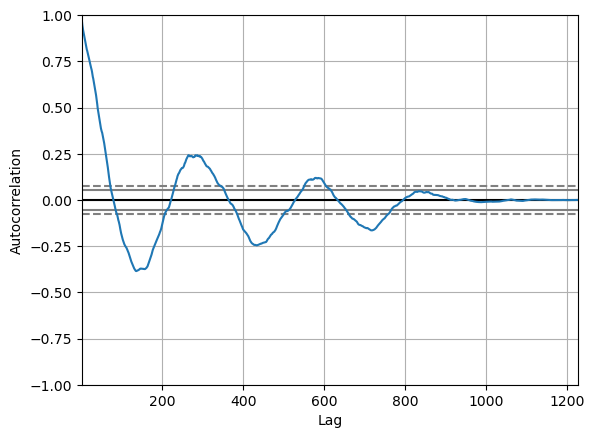

In [28]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2016':'2020']['Arrival Quantity'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

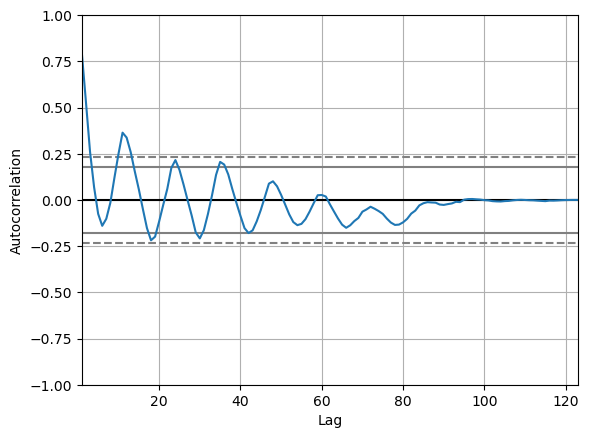

In [29]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2010':'2020']['Arrival Quantity'].resample('1m').max())

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

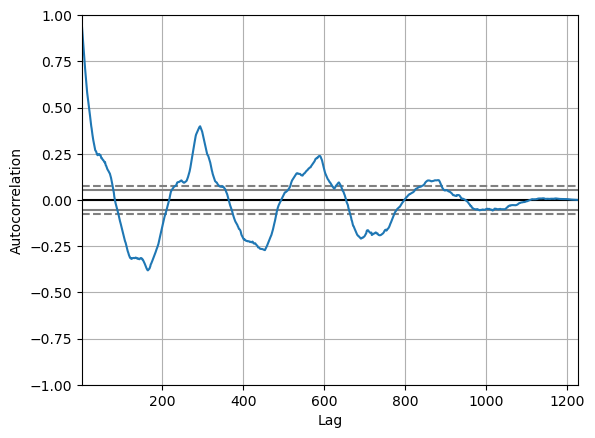

In [30]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2016':'2020']['Retail Prices'])

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

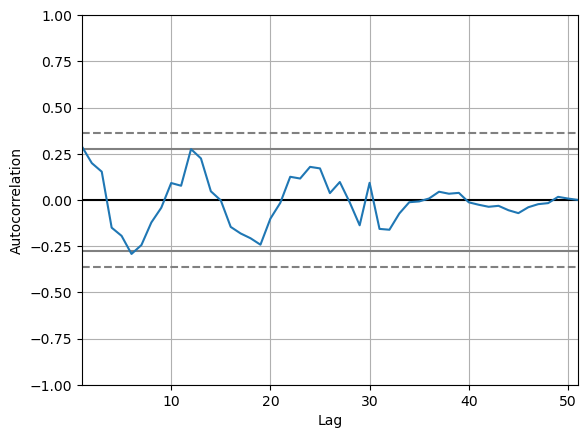

In [31]:
pd.plotting.autocorrelation_plot(df_Ranchi_dropped['2016':'2020']['Retail Prices'].resample('1m').max())

<Axes: xlabel='y(t)', ylabel='y(t + 4)'>

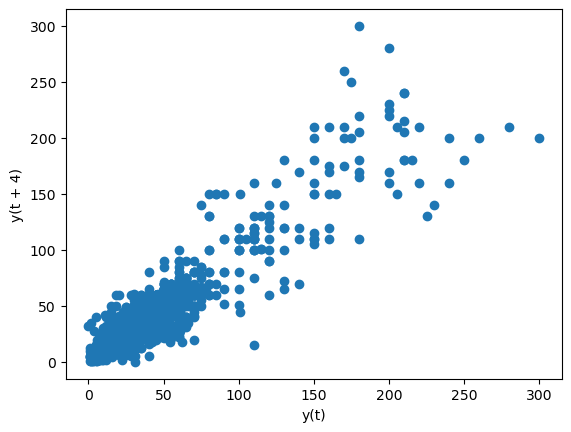

In [32]:
pd.plotting.lag_plot(df_Ranchi_1['Arrival Quantity'],lag=4)

<Axes: xlabel='y(t)', ylabel='y(t + 1)'>

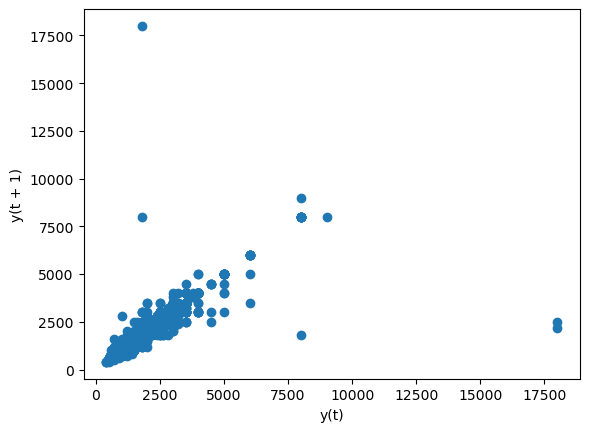

In [33]:
pd.plotting.lag_plot(df_Ranchi['Retail Prices'],lag=1)

In [34]:
from statsmodels.tsa.stattools import adfuller


# In[19]:


test_result=adfuller(df_Ranchi_dropped['Arrival Quantity'])


# In[20]:


#Ho: It is non stationary
#H1: It is stationary

def adfuller_test(sales):
    result=adfuller(sales)
    labels = ['ADF Test Statistic','p-value','#Lags Used','Number of Observations Used']
    for value,label in zip(result,labels):
        print(label+' : '+str(value) )
    if result[1] <= 0.05:
        print("strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary")
    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")


In [35]:
adfuller_test(df_Ranchi_dropped['Arrival Quantity'])

ADF Test Statistic : -4.493579348334501
p-value : 0.0002019601054302074
#Lags Used : 4
Number of Observations Used : 2920
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [36]:
adfuller_test(df_Ranchi_dropped['Retail Prices'])

ADF Test Statistic : -6.34920690147482
p-value : 2.636345497638967e-08
#Lags Used : 1
Number of Observations Used : 2923
strong evidence against the null hypothesis(Ho), reject the null hypothesis. Data has no unit root and is stationary


In [37]:
df_Ranchi.isnull().sum()

Arrival Quantity    882
Retail Prices       882
Min Price           882
Max Price           882
Modal Price         882
dtype: int64

# Applying similar procedure to drop outliers without losing NULL

In [38]:
df_Ranchi.fillna(-1,inplace=True)
df_Ranchi=df_Ranchi[df_Ranchi['Retail Prices']<10000]
df_Ranchi.replace(-1,np.nan,inplace=True)

# Imputing with rolling window size = adf lags

In [39]:
df_Ranchi_imp=pd.DataFrame()
df_Ranchi_imp['Retail Prices']=df_Ranchi['Retail Prices'].rolling(window=1,min_periods=0).mean().fillna(method='ffill')
df_Ranchi_imp['Arrival Quantity']=df_Ranchi['Arrival Quantity'].rolling(window=4,min_periods=2).mean().fillna(method='ffill')
df_Ranchi_imp['Retail Prices_lag']=df_Ranchi['Retail Prices'].rolling(window=1,min_periods=0).mean().fillna(method='ffill').shift(1)
# df_Ranchi_imp['Arrival Quantity']=df_Ranchi['Arrival Quantity'].rolling(window=5,min_periods=2).mean().fillna(method='bfill')
df_Ranchi_imp=df_Ranchi_imp.dropna()
#df_Ranchi_imp['2008':'2016']['Retail Prices'].plot()
df_Ranchi_imp[['Retail Prices','Retail Prices_lag']].iplot()
df_Ranchi_imp.isnull().sum()

Retail Prices        0
Arrival Quantity     0
Retail Prices_lag    0
dtype: int64

# Resampling daily data into monthly data

In [40]:
df_Ranchi_imp_month=pd.DataFrame()
df_Ranchi_imp_month['Retail Prices_lag']=df_Ranchi_imp['Retail Prices_lag'].resample('M').mean()
df_Ranchi_imp_month['Arrival Quantity']=df_Ranchi_imp['Arrival Quantity'].resample('M').max()
df_Ranchi_imp_month['Arrival Quantity_mean']=df_Ranchi_imp['Arrival Quantity'].resample('M').mean()
df_Ranchi_imp_month=df_Ranchi_imp_month.dropna()
df_Ranchi_imp_month.index = df_Ranchi_imp_month.index + pd.offsets.MonthBegin(0)
df_Ranchi_imp_month[['Arrival Quantity','Retail Prices_lag']].tail(6)

Arrival Quantity  Retail Prices_lag
Date                                           
2019-11-01         35.500000        3967.741935
2019-12-01         59.000000        2887.096774
2020-01-01         62.000000        1970.967742
2020-02-01         59.333333        2151.612903
2020-03-01         52.000000        1751.612903
2020-04-01         50.333333        1654.838710

# Reading csv file (Fertilizer subsidy rates, Diesel Reserves and Diesel Prices) 

In [41]:
df_1_new=pd.read_csv('/kaggle/input/tomtao-prices-a-q/multi/Fert_dies_price.csv',index_col=[0],parse_dates=True)
df_1_new

N       P       K      S  thousand million barrels  \
2010-01-01  23.227  26.276  24.487  1.784                  5.800000   
2010-04-01  23.227  26.276  24.487  1.784                  5.766667   
2010-10-01  23.227  25.950  24.237  1.784                  5.733333   
2011-01-01  23.227  25.624  23.987  1.784                  5.700000   
2011-04-01  27.153  32.338  26.756  1.677                  5.700000   
...            ...     ...     ...    ...                       ...   
2022-03-01  18.901  15.216  11.124  3.562                  4.700000   
2022-04-01  18.901  15.216  11.124  3.562                  4.700000   
2022-05-01  18.901  15.216  11.124  3.562                  4.700000   
2022-06-01  18.901  15.216  11.124  3.562                  4.700000   
2023-06-01  18.901  15.216  11.124  3.562                  4.700000   

                dprice  
2010-01-01   36.493899  
2010-04-01   36.493899  
2010-10-01   36.493899  
2011-01-01   38.805893  
2011-04-01   41.117887  
...                ...  
2022-03-01   90.914634  
2022-04-01  102.012197  
2022-05-01  102.225611  
2022-06-01   94.009148  
2023-06-01   94.756098  

[73 rows x 6 columns]

In [42]:
#df_1_new=pd.read_csv('FERTILIZERS.csv',names=['Date','N','P','K','S'],header=0,index_col=[0],parse_dates=True)
finaldf1=df_Ranchi_imp_month[['Arrival Quantity_mean','Retail Prices_lag']].copy()
finaldf1

Arrival Quantity_mean  Retail Prices_lag
Date                                                
2010-02-01              29.261111         796.666667
2010-03-01              27.405556         516.666667
2010-04-01              24.467742         912.903226
2010-05-01              22.201613         854.838710
2010-06-01              19.478495        1012.903226
...                           ...                ...
2019-12-01              49.508065        2887.096774
2020-01-01              54.040323        1970.967742
2020-02-01              47.110215        2151.612903
2020-03-01              45.776882        1751.612903
2020-04-01              40.588710        1654.838710

[123 rows x 2 columns]

# Merging original df with extra features

In [43]:
finaldf1=df_Ranchi_imp_month[['Arrival Quantity_mean','Retail Prices_lag']].copy()
df_concat_1 = pd.concat([finaldf1, df_1_new], axis=1, join='outer')
df_concat_1.loc[:,['N','P','K','S','thousand million barrels','dprice']]=df_concat_1.loc[:,['N','P','K','S','thousand million barrels','dprice']].interpolate().fillna(method='bfill')
df_concat_1.dropna(subset=['Arrival Quantity_mean','Retail Prices_lag'],inplace=True)
df_concat_1.head()

Arrival Quantity_mean  Retail Prices_lag       N          P  \
2010-02-01              29.261111         796.666667  23.227  26.276000   
2010-03-01              27.405556         516.666667  23.227  26.276000   
2010-04-01              24.467742         912.903226  23.227  26.276000   
2010-05-01              22.201613         854.838710  23.227  26.221667   
2010-06-01              19.478495        1012.903226  23.227  26.167333   

                    K      S  thousand million barrels     dprice  
2010-02-01  24.487000  1.784                  5.788889  36.493899  
2010-03-01  24.487000  1.784                  5.777778  36.493899  
2010-04-01  24.487000  1.784                  5.766667  36.493899  
2010-05-01  24.445333  1.784                  5.761111  36.493899  
2010-06-01  24.403667  1.784                  5.755556  36.493899

# Creating meaningful features like NBS rates using N,P,K 

In [44]:
df_concat_1['NBS rate']=3*df_concat_1['N']+1.5*df_concat_1['P']+df_concat_1['K']
df_concat_1=df_concat_1.loc[:,['Arrival Quantity_mean','Retail Prices_lag','NBS rate','thousand million barrels','dprice']]
df_concat_1

Arrival Quantity_mean  Retail Prices_lag    NBS rate  \
2010-02-01              29.261111         796.666667  133.582000   
2010-03-01              27.405556         516.666667  133.582000   
2010-04-01              24.467742         912.903226  133.582000   
2010-05-01              22.201613         854.838710  133.458833   
2010-06-01              19.478495        1012.903226  133.335667   
...                           ...                ...         ...   
2019-12-01              49.508065        2887.096774   90.651000   
2020-01-01              54.040323        1970.967742   90.651000   
2020-02-01              47.110215        2151.612903   90.651000   
2020-03-01              45.776882        1751.612903   90.651000   
2020-04-01              40.588710        1654.838710   90.651000   

            thousand million barrels     dprice  
2010-02-01                  5.788889  36.493899  
2010-03-01                  5.777778  36.493899  
2010-04-01                  5.766667  36.493899  
2010-05-01                  5.761111  36.493899  
2010-06-01                  5.755556  36.493899  
...                              ...        ...  
2019-12-01                  4.700000  66.798783  
2020-01-01                  4.700000  68.826220  
2020-02-01                  4.700000  70.853658  
2020-03-01                  4.700000  67.225611  
2020-04-01                  4.700000  63.597564  

[123 rows x 5 columns]

# Reading Rainfall data, resampling it using sum attribute and cropping according to original indexes

In [45]:
df_rain=pd.read_csv('/kaggle/input/tomtao-prices-a-q/multi/Rainfall.csv',index_col=[0],parse_dates=True)
df_rain

Rainfall
2010-01-01       0.0
2010-02-01      14.8
2010-03-01       0.0
2010-04-01      15.4
2010-05-01      30.1
...              ...
2019-12-01      16.5
2020-01-01      21.7
2020-02-01       3.8
2020-03-01      73.0
2020-04-01      43.8

[124 rows x 1 columns]

In [46]:
df_rain_m=df_rain.resample('MS').sum()

In [47]:
df_rain_m

Rainfall
2010-01-01       0.0
2010-02-01      14.8
2010-03-01       0.0
2010-04-01      15.4
2010-05-01      30.1
...              ...
2019-12-01      16.5
2020-01-01      21.7
2020-02-01       3.8
2020-03-01      73.0
2020-04-01      43.8

[124 rows x 1 columns]

In [48]:
df_rain_m=df_rain_m.loc[df_concat_1.index,:]
df_rain_m

Rainfall
2010-02-01      14.8
2010-03-01       0.0
2010-04-01      15.4
2010-05-01      30.1
2010-06-01      66.6
...              ...
2019-12-01      16.5
2020-01-01      21.7
2020-02-01       3.8
2020-03-01      73.0
2020-04-01      43.8

[123 rows x 1 columns]

# Reading Temp data, resampling it using sum attribute and cropping according to original indexes

In [49]:
df_temp=pd.read_csv('/kaggle/input/tomtao-prices-a-q/Ranchi_temp_data.csv',index_col=[0],parse_dates=True)
df_temp=df_temp.loc[df_concat_1.index[:-4],['tasmin','tasmax']]
df_temp

tasmin     tasmax
2010-02-01  13.500000  27.875000
2010-03-01  19.450000  34.450000
2010-04-01  23.950000  38.925000
2010-05-01  25.100002  38.800000
2010-06-01  25.824999  36.025000
...               ...        ...
2019-08-01  23.525000  30.650002
2019-09-01  22.550000  30.175001
2019-10-01  19.625000  29.224998
2019-11-01  15.175000  27.200000
2019-12-01   9.975000  22.275002

[119 rows x 2 columns]

In [50]:
df_concat_1=pd.concat([df_concat_1,df_rain_m,df_temp],axis=1)
df_concat_1

Arrival Quantity_mean  Retail Prices_lag    NBS rate  \
2010-02-01              29.261111         796.666667  133.582000   
2010-03-01              27.405556         516.666667  133.582000   
2010-04-01              24.467742         912.903226  133.582000   
2010-05-01              22.201613         854.838710  133.458833   
2010-06-01              19.478495        1012.903226  133.335667   
...                           ...                ...         ...   
2019-12-01              49.508065        2887.096774   90.651000   
2020-01-01              54.040323        1970.967742   90.651000   
2020-02-01              47.110215        2151.612903   90.651000   
2020-03-01              45.776882        1751.612903   90.651000   
2020-04-01              40.588710        1654.838710   90.651000   

            thousand million barrels     dprice  Rainfall     tasmin  \
2010-02-01                  5.788889  36.493899      14.8  13.500000   
2010-03-01                  5.777778  36.493899       0.0  19.450000   
2010-04-01                  5.766667  36.493899      15.4  23.950000   
2010-05-01                  5.761111  36.493899      30.1  25.100002   
2010-06-01                  5.755556  36.493899      66.6  25.824999   
...                              ...        ...       ...        ...   
2019-12-01                  4.700000  66.798783      16.5   9.975000   
2020-01-01                  4.700000  68.826220      21.7        NaN   
2020-02-01                  4.700000  70.853658       3.8        NaN   
2020-03-01                  4.700000  67.225611      73.0        NaN   
2020-04-01                  4.700000  63.597564      43.8        NaN   

               tasmax  
2010-02-01  27.875000  
2010-03-01  34.450000  
2010-04-01  38.925000  
2010-05-01  38.800000  
2010-06-01  36.025000  
...               ...  
2019-12-01  22.275002  
2020-01-01        NaN  
2020-02-01        NaN  
2020-03-01        NaN  
2020-04-01        NaN  

[123 rows x 8 columns]

# Merging GDP and CPI onto new dataframe

In [51]:
df_new=pd.read_csv('/kaggle/input/tomtao-prices-a-q/multi/gdp and cpi merged.csv',index_col=0,parse_dates=True)
finaldf1=df_concat_1.merge(df_new,on=df_concat_1.index)
finaldf1=finaldf1.iloc[:-4,:]

# Final dataframe with mean (arrival qty)

In [52]:
finaldf1

key_0  Arrival Quantity_mean  Retail Prices_lag    NBS rate  \
0   2010-02-01              29.261111         796.666667  133.582000   
1   2010-03-01              27.405556         516.666667  133.582000   
2   2010-04-01              24.467742         912.903226  133.582000   
3   2010-05-01              22.201613         854.838710  133.458833   
4   2010-06-01              19.478495        1012.903226  133.335667   
..         ...                    ...                ...         ...   
114 2019-08-01              16.099462        3274.193548   90.651000   
115 2019-09-01              12.733871        3774.193548   90.651000   
116 2019-10-01              51.018817        2845.161290   90.651000   
117 2019-11-01              23.271505        3967.741935   90.651000   
118 2019-12-01              49.508065        2887.096774   90.651000   

     thousand million barrels     dprice  Rainfall     tasmin     tasmax  \
0                    5.788889  36.493899      14.8  13.500000  27.875000   
1                    5.777778  36.493899       0.0  19.450000  34.450000   
2                    5.766667  36.493899      15.4  23.950000  38.925000   
3                    5.761111  36.493899      30.1  25.100002  38.800000   
4                    5.755556  36.493899      66.6  25.824999  36.025000   
..                        ...        ...       ...        ...        ...   
114                  4.700000  67.332319     201.6  23.525000  30.650002   
115                  4.700000  66.265245     173.9  22.550000  30.175001   
116                  4.700000  69.253048      92.6  19.625000  29.224998   
117                  4.700000  68.025915       0.3  15.175000  27.200000   
118                  4.700000  66.798783      16.5   9.975000  22.275002   

            CPI        GDP  
0     65.030284   99.41989  
1     65.030284   99.62147  
2     65.030284   99.81792  
3     65.795346  100.00665  
4     66.560408  100.18442  
..          ...        ...  
114  122.409946  100.58100  
115  123.175008  100.43866  
116  124.322601  100.27402  
117  125.470194  100.08812  
118  126.235257   99.88208  

[119 rows x 11 columns]

# Making it ready-to-use for prophet model 

In [53]:
finaldf1['ds'] = pd.to_datetime(finaldf1.key_0)
finaldf1.drop('key_0',axis=1,inplace=True)
finaldf1
finaldf1.rename(columns={'Retail Prices_lag':'y'},inplace=True)
finaldf1.tail()

Arrival Quantity_mean            y  NBS rate  thousand million barrels  \
114              16.099462  3274.193548    90.651                       4.7   
115              12.733871  3774.193548    90.651                       4.7   
116              51.018817  2845.161290    90.651                       4.7   
117              23.271505  3967.741935    90.651                       4.7   
118              49.508065  2887.096774    90.651                       4.7   

        dprice  Rainfall  tasmin     tasmax         CPI        GDP         ds  
114  67.332319     201.6  23.525  30.650002  122.409946  100.58100 2019-08-01  
115  66.265245     173.9  22.550  30.175001  123.175008  100.43866 2019-09-01  
116  69.253048      92.6  19.625  29.224998  124.322601  100.27402 2019-10-01  
117  68.025915       0.3  15.175  27.200000  125.470194  100.08812 2019-11-01  
118  66.798783      16.5   9.975  22.275002  126.235257   99.88208 2019-12-01

# Repeating the same process of concatenation for max (arrival qty)

In [54]:
df_1_new

N       P       K      S  thousand million barrels  \
2010-01-01  23.227  26.276  24.487  1.784                  5.800000   
2010-04-01  23.227  26.276  24.487  1.784                  5.766667   
2010-10-01  23.227  25.950  24.237  1.784                  5.733333   
2011-01-01  23.227  25.624  23.987  1.784                  5.700000   
2011-04-01  27.153  32.338  26.756  1.677                  5.700000   
...            ...     ...     ...    ...                       ...   
2022-03-01  18.901  15.216  11.124  3.562                  4.700000   
2022-04-01  18.901  15.216  11.124  3.562                  4.700000   
2022-05-01  18.901  15.216  11.124  3.562                  4.700000   
2022-06-01  18.901  15.216  11.124  3.562                  4.700000   
2023-06-01  18.901  15.216  11.124  3.562                  4.700000   

                dprice  
2010-01-01   36.493899  
2010-04-01   36.493899  
2010-10-01   36.493899  
2011-01-01   38.805893  
2011-04-01   41.117887  
...                ...  
2022-03-01   90.914634  
2022-04-01  102.012197  
2022-05-01  102.225611  
2022-06-01   94.009148  
2023-06-01   94.756098  

[73 rows x 6 columns]

In [55]:
finaldf=df_Ranchi_imp_month[['Arrival Quantity','Retail Prices_lag']].copy()
df_concat = pd.concat([finaldf, df_1_new], axis=1, join='outer')
df_concat.loc[:,['N','P','K','S','thousand million barrels','dprice']]=df_concat.loc[:,['N','P','K','S','thousand million barrels','dprice']].interpolate().fillna(method='bfill')
df_concat.dropna(subset=['Arrival Quantity','Retail Prices_lag'],inplace=True)
df_concat.tail()

Arrival Quantity  Retail Prices_lag       N       P       K  \
2019-12-01         59.000000        2887.096774  18.901  15.216  11.124   
2020-01-01         62.000000        1970.967742  18.901  15.216  11.124   
2020-02-01         59.333333        2151.612903  18.901  15.216  11.124   
2020-03-01         52.000000        1751.612903  18.901  15.216  11.124   
2020-04-01         50.333333        1654.838710  18.901  15.216  11.124   

                S  thousand million barrels     dprice  
2019-12-01  3.562                       4.7  66.798783  
2020-01-01  3.562                       4.7  68.826220  
2020-02-01  3.562                       4.7  70.853658  
2020-03-01  3.562                       4.7  67.225611  
2020-04-01  3.562                       4.7  63.597564

In [56]:
df_concat['NBS rate']=3*df_concat['N']+1.5*df_concat['P']+df_concat['K']
df_concat=df_concat.loc[:,['Arrival Quantity','Retail Prices_lag','NBS rate','thousand million barrels','dprice']]
df_concat

Arrival Quantity  Retail Prices_lag    NBS rate  \
2010-02-01         35.333333         796.666667  133.582000   
2010-03-01         29.750000         516.666667  133.582000   
2010-04-01         30.500000         912.903226  133.582000   
2010-05-01         26.666667         854.838710  133.458833   
2010-06-01         26.666667        1012.903226  133.335667   
...                      ...                ...         ...   
2019-12-01         59.000000        2887.096774   90.651000   
2020-01-01         62.000000        1970.967742   90.651000   
2020-02-01         59.333333        2151.612903   90.651000   
2020-03-01         52.000000        1751.612903   90.651000   
2020-04-01         50.333333        1654.838710   90.651000   

            thousand million barrels     dprice  
2010-02-01                  5.788889  36.493899  
2010-03-01                  5.777778  36.493899  
2010-04-01                  5.766667  36.493899  
2010-05-01                  5.761111  36.493899  
2010-06-01                  5.755556  36.493899  
...                              ...        ...  
2019-12-01                  4.700000  66.798783  
2020-01-01                  4.700000  68.826220  
2020-02-01                  4.700000  70.853658  
2020-03-01                  4.700000  67.225611  
2020-04-01                  4.700000  63.597564  

[123 rows x 5 columns]

In [57]:
df_concat=pd.concat([df_concat,df_rain_m,df_temp],axis=1)
df_concat

Arrival Quantity  Retail Prices_lag    NBS rate  \
2010-02-01         35.333333         796.666667  133.582000   
2010-03-01         29.750000         516.666667  133.582000   
2010-04-01         30.500000         912.903226  133.582000   
2010-05-01         26.666667         854.838710  133.458833   
2010-06-01         26.666667        1012.903226  133.335667   
...                      ...                ...         ...   
2019-12-01         59.000000        2887.096774   90.651000   
2020-01-01         62.000000        1970.967742   90.651000   
2020-02-01         59.333333        2151.612903   90.651000   
2020-03-01         52.000000        1751.612903   90.651000   
2020-04-01         50.333333        1654.838710   90.651000   

            thousand million barrels     dprice  Rainfall     tasmin  \
2010-02-01                  5.788889  36.493899      14.8  13.500000   
2010-03-01                  5.777778  36.493899       0.0  19.450000   
2010-04-01                  5.766667  36.493899      15.4  23.950000   
2010-05-01                  5.761111  36.493899      30.1  25.100002   
2010-06-01                  5.755556  36.493899      66.6  25.824999   
...                              ...        ...       ...        ...   
2019-12-01                  4.700000  66.798783      16.5   9.975000   
2020-01-01                  4.700000  68.826220      21.7        NaN   
2020-02-01                  4.700000  70.853658       3.8        NaN   
2020-03-01                  4.700000  67.225611      73.0        NaN   
2020-04-01                  4.700000  63.597564      43.8        NaN   

               tasmax  
2010-02-01  27.875000  
2010-03-01  34.450000  
2010-04-01  38.925000  
2010-05-01  38.800000  
2010-06-01  36.025000  
...               ...  
2019-12-01  22.275002  
2020-01-01        NaN  
2020-02-01        NaN  
2020-03-01        NaN  
2020-04-01        NaN  

[123 rows x 8 columns]

In [58]:
df_new=pd.read_csv('/kaggle/input/tomtao-prices-a-q/multi/gdp and cpi merged.csv',index_col=0,parse_dates=True)
finaldf=df_concat.merge(df_new,on=df_concat.index)
finaldf=finaldf.iloc[:-4,:]
finaldf

key_0  Arrival Quantity  Retail Prices_lag    NBS rate  \
0   2010-02-01         35.333333         796.666667  133.582000   
1   2010-03-01         29.750000         516.666667  133.582000   
2   2010-04-01         30.500000         912.903226  133.582000   
3   2010-05-01         26.666667         854.838710  133.458833   
4   2010-06-01         26.666667        1012.903226  133.335667   
..         ...               ...                ...         ...   
114 2019-08-01         23.500000        3274.193548   90.651000   
115 2019-09-01         28.750000        3774.193548   90.651000   
116 2019-10-01         58.333333        2845.161290   90.651000   
117 2019-11-01         35.500000        3967.741935   90.651000   
118 2019-12-01         59.000000        2887.096774   90.651000   

     thousand million barrels     dprice  Rainfall     tasmin     tasmax  \
0                    5.788889  36.493899      14.8  13.500000  27.875000   
1                    5.777778  36.493899       0.0  19.450000  34.450000   
2                    5.766667  36.493899      15.4  23.950000  38.925000   
3                    5.761111  36.493899      30.1  25.100002  38.800000   
4                    5.755556  36.493899      66.6  25.824999  36.025000   
..                        ...        ...       ...        ...        ...   
114                  4.700000  67.332319     201.6  23.525000  30.650002   
115                  4.700000  66.265245     173.9  22.550000  30.175001   
116                  4.700000  69.253048      92.6  19.625000  29.224998   
117                  4.700000  68.025915       0.3  15.175000  27.200000   
118                  4.700000  66.798783      16.5   9.975000  22.275002   

            CPI        GDP  
0     65.030284   99.41989  
1     65.030284   99.62147  
2     65.030284   99.81792  
3     65.795346  100.00665  
4     66.560408  100.18442  
..          ...        ...  
114  122.409946  100.58100  
115  123.175008  100.43866  
116  124.322601  100.27402  
117  125.470194  100.08812  
118  126.235257   99.88208  

[119 rows x 11 columns]

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >,
       <Axes: >, <Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

<Figure size 5000x1200 with 0 Axes>

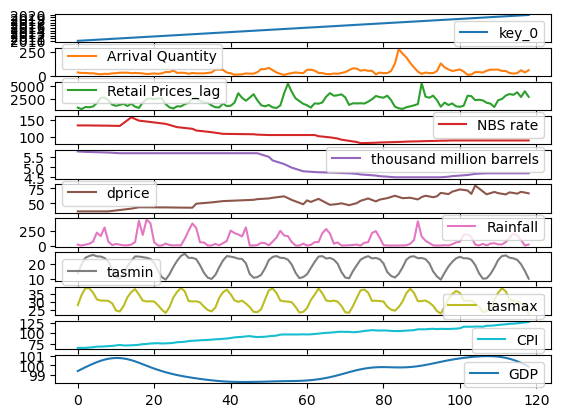

In [59]:
plt.figure(figsize=(50,12))
finaldf.plot(subplots=True)

In [60]:
finaldf['ds'] = finaldf['key_0']
finaldf.drop('key_0',axis=1,inplace=True)
finaldf
finaldf.rename(columns={'Retail Prices_lag':'y'},inplace=True)
finaldf.tail()

Arrival Quantity            y  NBS rate  thousand million barrels  \
114         23.500000  3274.193548    90.651                       4.7   
115         28.750000  3774.193548    90.651                       4.7   
116         58.333333  2845.161290    90.651                       4.7   
117         35.500000  3967.741935    90.651                       4.7   
118         59.000000  2887.096774    90.651                       4.7   

        dprice  Rainfall  tasmin     tasmax         CPI        GDP         ds  
114  67.332319     201.6  23.525  30.650002  122.409946  100.58100 2019-08-01  
115  66.265245     173.9  22.550  30.175001  123.175008  100.43866 2019-09-01  
116  69.253048      92.6  19.625  29.224998  124.322601  100.27402 2019-10-01  
117  68.025915       0.3  15.175  27.200000  125.470194  100.08812 2019-11-01  
118  66.798783      16.5   9.975  22.275002  126.235257   99.88208 2019-12-01

In [61]:
finaldf['ds']

0     2010-02-01
1     2010-03-01
2     2010-04-01
3     2010-05-01
4     2010-06-01
         ...    
114   2019-08-01
115   2019-09-01
116   2019-10-01
117   2019-11-01
118   2019-12-01
Name: ds, Length: 119, dtype: datetime64[ns]

In [62]:
finaldf.isnull().sum()

Arrival Quantity            0
y                           0
NBS rate                    0
thousand million barrels    0
dprice                      0
Rainfall                    0
tasmin                      0
tasmax                      0
CPI                         0
GDP                         0
ds                          0
dtype: int64

# Checking correlations

In [63]:
finaldf1.corr()

/tmp/ipykernel_20/3994723824.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Arrival Quantity_mean         y  NBS rate  \
Arrival Quantity_mean                  1.000000 -0.446381 -0.357434   
y                                     -0.446381  1.000000 -0.254825   
NBS rate                              -0.357434 -0.254825  1.000000   
thousand million barrels              -0.373906 -0.246545  0.874569   
dprice                                 0.257630  0.219920 -0.801271   
Rainfall                              -0.348174  0.234084  0.163074   
tasmin                                -0.194853  0.094416  0.055335   
tasmax                                 0.018781 -0.232990  0.091114   
CPI                                    0.271719  0.347382 -0.915418   
GDP                                    0.127939  0.010794 -0.094866   

                          thousand million barrels    dprice  Rainfall  \
Arrival Quantity_mean                    -0.373906  0.257630 -0.348174   
y                                        -0.246545  0.219920  0.234084   
NBS rate                                  0.874569 -0.801271  0.163074   
thousand million barrels                  1.000000 -0.711089  0.158210   
dprice                                   -0.711089  1.000000 -0.109674   
Rainfall                                  0.158210 -0.109674  1.000000   
tasmin                                    0.032149 -0.033911  0.558571   
tasmax                                    0.066244 -0.060909  0.160680   
CPI                                      -0.882063  0.900656 -0.110525   
GDP                                      -0.343118  0.221427 -0.063165   

                            tasmin    tasmax       CPI       GDP  
Arrival Quantity_mean    -0.194853  0.018781  0.271719  0.127939  
y                         0.094416 -0.232990  0.347382  0.010794  
NBS rate                  0.055335  0.091114 -0.915418 -0.094866  
thousand million barrels  0.032149  0.066244 -0.882063 -0.343118  
dprice                   -0.033911 -0.060909  0.900656  0.221427  
Rainfall                  0.558571  0.160680 -0.110525 -0.063165  
tasmin                    1.000000  0.849144 -0.044428  0.035091  
tasmax                    0.849144  1.000000 -0.107263  0.026659  
CPI                      -0.044428 -0.107263  1.000000  0.254317  
GDP                       0.035091  0.026659  0.254317  1.000000

In [64]:
finaldf.corr()

/tmp/ipykernel_20/1371853549.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Arrival Quantity         y  NBS rate  \
Arrival Quantity                  1.000000 -0.421811 -0.362812   
y                                -0.421811  1.000000 -0.254825   
NBS rate                         -0.362812 -0.254825  1.000000   
thousand million barrels         -0.372114 -0.246545  0.874569   
dprice                            0.276500  0.219920 -0.801271   
Rainfall                         -0.322222  0.234084  0.163074   
tasmin                           -0.190142  0.094416  0.055335   
tasmax                            0.005568 -0.232990  0.091114   
CPI                               0.275259  0.347382 -0.915418   
GDP                               0.098379  0.010794 -0.094866   

                          thousand million barrels    dprice  Rainfall  \
Arrival Quantity                         -0.372114  0.276500 -0.322222   
y                                        -0.246545  0.219920  0.234084   
NBS rate                                  0.874569 -0.801271  0.163074   
thousand million barrels                  1.000000 -0.711089  0.158210   
dprice                                   -0.711089  1.000000 -0.109674   
Rainfall                                  0.158210 -0.109674  1.000000   
tasmin                                    0.032149 -0.033911  0.558571   
tasmax                                    0.066244 -0.060909  0.160680   
CPI                                      -0.882063  0.900656 -0.110525   
GDP                                      -0.343118  0.221427 -0.063165   

                            tasmin    tasmax       CPI       GDP  
Arrival Quantity         -0.190142  0.005568  0.275259  0.098379  
y                         0.094416 -0.232990  0.347382  0.010794  
NBS rate                  0.055335  0.091114 -0.915418 -0.094866  
thousand million barrels  0.032149  0.066244 -0.882063 -0.343118  
dprice                   -0.033911 -0.060909  0.900656  0.221427  
Rainfall                  0.558571  0.160680 -0.110525 -0.063165  
tasmin                    1.000000  0.849144 -0.044428  0.035091  
tasmax                    0.849144  1.000000 -0.107263  0.026659  
CPI                      -0.044428 -0.107263  1.000000  0.254317  
GDP                       0.035091  0.026659  0.254317  1.000000

# Using simple prophet model

In [65]:
# splitting train and test data
trainDataSize = 0.80
splitSize = int(finaldf.shape[0]*trainDataSize)
print(splitSize)
train = finaldf[0:splitSize]
test = finaldf[splitSize:]
print(train.shape)
print(test.shape)

prophetColumns =['Arrival Quantity','CPI','GDP','NBS rate','thousand million barrels']
# model

model = Prophet()

# adding all columns in add regressor
for col in prophetColumns:
    model.add_regressor(col)
#training model
model.fit(train)

future =test.copy()
future.drop('y',axis=1,inplace=True)

#prediction
prediction = model.predict(future)

05:00:25 - cmdstanpy - INFO - Chain [1] start processing


95
(95, 11)
(24, 11)


05:00:25 - cmdstanpy - INFO - Chain [1] done processing


MAE: 585.097
MAPE: 0.3166573238048836


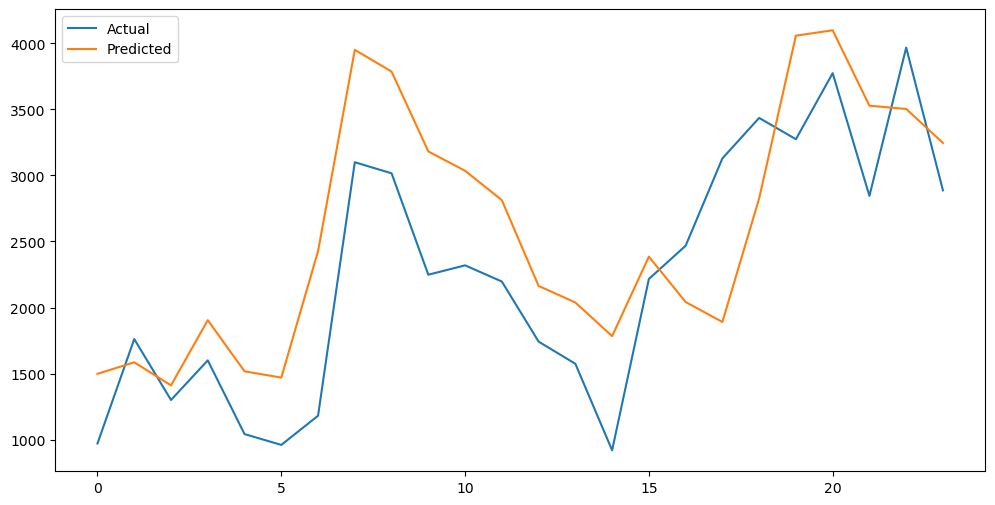

In [66]:
y_true = test['y'].values
y_pred = prediction['yhat'].values


plt.figure(figsize=(12, 6))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [67]:
# import plotly.io as pio
# pio.renderers.default = 'colab'

In [68]:
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_true, name="actual targets"),)
    #secondary_y=False,)
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_pred, name="predicted targets"),)
    #secondary_y=True,)
fig.add_trace(go.Scatter(x=finaldf['ds'].values, y=finaldf['y'].values, name="original data"),)
    #secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

# Modifying trend flexibility & amount of historical data to be included for detecting trend changepoints.

05:00:33 - cmdstanpy - INFO - Chain [1] start processing


95
(95, 11)
(24, 11)


05:00:33 - cmdstanpy - INFO - Chain [1] done processing


MAE: 634.394
MAPE: 0.34503378577295446


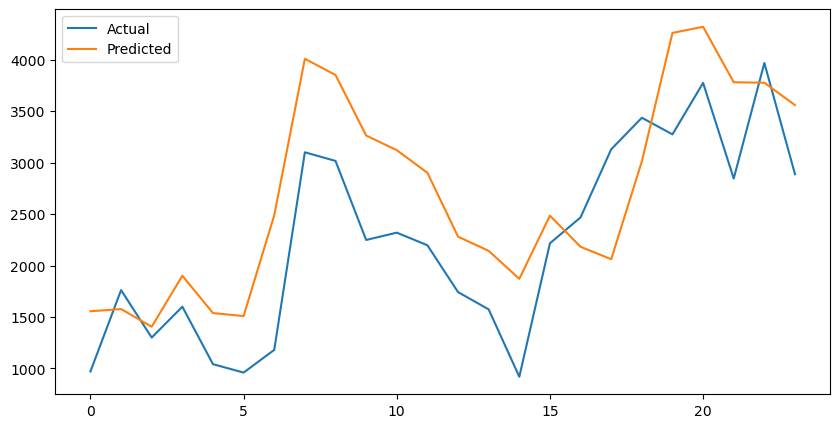

In [69]:
#Trial 2

# splitting train and test data
trainDataSize = 0.80
splitSize = int(finaldf.shape[0]*trainDataSize)
print(splitSize)
train = finaldf[0:splitSize]
test = finaldf[splitSize:]
print(train.shape)
print(test.shape)
prophetColumns =['Arrival Quantity','CPI','GDP','NBS rate']
# model

#seasonality_mode = 'multiplicative'

#modelWeekly = Prophet(changepoint_range=0.90,changepoint_prior_scale = 0.5)

model = Prophet(changepoint_range=0.95,changepoint_prior_scale = 1,)#seasonality_prior_scale=20)

# adding all columns in add regressor
for col in prophetColumns:
    model.add_regressor(col)
#training model
model.fit(train)

future =test.copy()
future.drop('y',axis=1,inplace=True)

#prediction
prediction = model.predict(future)

y_true = test['y'].values
y_pred = prediction['yhat'].values


plt.figure(figsize=(10, 5))
mae = mean_absolute_error(y_true, y_pred)
print('MAE: %.3f' % mae)
mape = mean_absolute_percentage_error(y_true, y_pred)
print("MAPE:", mape)
# plot expected vs actual
plt.plot(y_true, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()

In [70]:
# with extreme weather and 80% train data, seasonality mode mulitplicative
fig = make_subplots(specs=[[{"secondary_y": True}]])
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_true, name="actual targets"),)
    #secondary_y=False,)
fig.add_trace(
    go.Scatter(x=test['ds'].values, y=y_pred, name="predicted targets"),)
    #secondary_y=True,)
fig.add_trace(go.Scatter(x=finaldf['ds'].values, y=finaldf['y'].values, name="original data"),)
    #secondary_y=True,)
fig.update_layout(
    title_text="Actual vs Predicted Targets")
fig.update_xaxes(title_text="Timeline")
fig.update_yaxes(title_text="actual targets", secondary_y=False)
fig.update_yaxes(title_text="predicted targets", secondary_y=True)
fig.show()

In [71]:
finaldf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 119 entries, 0 to 118
Data columns (total 11 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Arrival Quantity          119 non-null    float64       
 1   y                         119 non-null    float64       
 2   NBS rate                  119 non-null    float64       
 3   thousand million barrels  119 non-null    float64       
 4   dprice                    119 non-null    float64       
 5   Rainfall                  119 non-null    float64       
 6   tasmin                    119 non-null    float64       
 7   tasmax                    119 non-null    float64       
 8   CPI                       119 non-null    float64       
 9   GDP                       119 non-null    float64       
 10  ds                        119 non-null    datetime64[ns]
dtypes: datetime64[ns](1), float64(10)
memory usage: 11.2 KB


# Implementing prophet model with 95% cofidence interval

In [72]:
def model_prophet(Prophetdf,n_obs= 113):

    Prophetdf_train=Prophetdf[0:n_obs]
    Prophetdf_test =Prophetdf[n_obs:]
    multi_model = Prophet(interval_width = 0.95)
    Prophet_cols = Prophetdf.columns.tolist()
    Prophet_cols.remove('ds')
    Prophet_cols.remove('y')
    print(Prophetdf_train.columns)
    #print(Prophetdf_test[['ds','y']])

    # adding all columns in add regressor
    for col in Prophet_cols:
        multi_model.add_regressor(col)


    multi_model.fit(Prophetdf_train)
    print('Prophetdf_test.shape[0]')
    print(Prophetdf_test.shape[0])
    # make furture frame
    future = multi_model.make_future_dataframe(periods = Prophetdf_test.shape[0],freq='MS', include_history=True)
    for col in Prophet_cols:
        future[col] =Prophetdf[col]
    print(Prophetdf_test[['ds','y']])
    print('future')
    print(future)

    # predict future
    forecastProphet =  multi_model.predict(future)
    combined_df = pd.merge(Prophetdf_test[['ds','y']],forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']], on='ds')

    print(forecastProphet[['ds','yhat', 'yhat_lower','yhat_upper']].tail())

    fig1 = multi_model.plot(forecastProphet)

    Prophetdf.plot(x = 'ds', y = 'y')

    multi_model.plot_components(forecastProphet);


    #print(Prophetdf_test[['ds','y']])
    print(forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-6:])

    combined_df = pd.merge(Prophetdf_test[['ds','y']],forecastProphet[['ds', 'yhat', 'yhat_lower', 'yhat_upper']][-6:], on='ds')
    #print(combined_df.head())


    #Check MAE value
    MAE = mean_absolute_error(combined_df['y'], combined_df['yhat'])
    print('MAE')
    print(MAE)

#Check MAPE value
    MAPE = mean_absolute_percentage_error(combined_df['y'], combined_df['yhat'])
    print('MAPE')
    print(MAPE)

    import seaborn as sns
    import matplotlib.pyplot as plt
    plt.rcParams.update({'figure.figsize':  (15, 3),  'figure.dpi' : 300})
    fig, ax = plt.subplots()

    sns.lineplot(data = Prophetdf , x = 'ds', y = 'y' ,label = 'Original')
    sns.lineplot(data= forecastProphet, x = 'ds', y = 'yhat', label = 'Forecast')
    plt.grid(linestyle = '-', linewidth = 0.3)

    plt.legend(["Original","forecast"])


    import seaborn as sns
    import matplotlib.pyplot as plt

    plt.rcParams.update({'figure.figsize':  (15, 3),  'figure.dpi' : 300})
    fig, ax = plt.subplots()
    sns.lineplot(data = Prophetdf[-6:] , x = 'ds', y = 'y' ,label = 'Original')
    sns.lineplot(data= forecastProphet[-6:], x = 'ds', y = 'yhat', label = 'Forecast')
    plt.grid(linestyle = '-', linewidth = 0.3)
    plt.legend(["Original","forecast"])
    return MAE

In [73]:
finaldf.head()

Arrival Quantity            y    NBS rate  thousand million barrels  \
0         35.333333   796.666667  133.582000                  5.788889   
1         29.750000   516.666667  133.582000                  5.777778   
2         30.500000   912.903226  133.582000                  5.766667   
3         26.666667   854.838710  133.458833                  5.761111   
4         26.666667  1012.903226  133.335667                  5.755556   

      dprice  Rainfall     tasmin  tasmax        CPI        GDP         ds  
0  36.493899      14.8  13.500000  27.875  65.030284   99.41989 2010-02-01  
1  36.493899       0.0  19.450000  34.450  65.030284   99.62147 2010-03-01  
2  36.493899      15.4  23.950000  38.925  65.030284   99.81792 2010-04-01  
3  36.493899      30.1  25.100002  38.800  65.795346  100.00665 2010-05-01  
4  36.493899      66.6  25.824999  36.025  66.560408  100.18442 2010-06-01

In [74]:
finaldf1.head()

Arrival Quantity_mean            y    NBS rate  thousand million barrels  \
0              29.261111   796.666667  133.582000                  5.788889   
1              27.405556   516.666667  133.582000                  5.777778   
2              24.467742   912.903226  133.582000                  5.766667   
3              22.201613   854.838710  133.458833                  5.761111   
4              19.478495  1012.903226  133.335667                  5.755556   

      dprice  Rainfall     tasmin  tasmax        CPI        GDP         ds  
0  36.493899      14.8  13.500000  27.875  65.030284   99.41989 2010-02-01  
1  36.493899       0.0  19.450000  34.450  65.030284   99.62147 2010-03-01  
2  36.493899      15.4  23.950000  38.925  65.030284   99.81792 2010-04-01  
3  36.493899      30.1  25.100002  38.800  65.795346  100.00665 2010-05-01  
4  36.493899      66.6  25.824999  36.025  66.560408  100.18442 2010-06-01

In [75]:
finaldf1.iplot()

In [76]:
#HERE we can see that MAE for arrival quantity mean(589.63) resampling is significantly less than that calculated using max resampling(608.94)

# Dropping Diesel reserves,CPI and Tasmin

In [77]:
finaldf.drop(['thousand million barrels','CPI','tasmin'],axis=1,inplace=True)
finaldf.columns

Index(['Arrival Quantity', 'y', 'NBS rate', 'dprice', 'Rainfall', 'tasmax',
       'GDP', 'ds'],
      dtype='object')

In [78]:
finaldf.corr()

/tmp/ipykernel_20/1371853549.py:1: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



Arrival Quantity         y  NBS rate    dprice  Rainfall  \
Arrival Quantity          1.000000 -0.421811 -0.362812  0.276500 -0.322222   
y                        -0.421811  1.000000 -0.254825  0.219920  0.234084   
NBS rate                 -0.362812 -0.254825  1.000000 -0.801271  0.163074   
dprice                    0.276500  0.219920 -0.801271  1.000000 -0.109674   
Rainfall                 -0.322222  0.234084  0.163074 -0.109674  1.000000   
tasmax                    0.005568 -0.232990  0.091114 -0.060909  0.160680   
GDP                       0.098379  0.010794 -0.094866  0.221427 -0.063165   

                    tasmax       GDP  
Arrival Quantity  0.005568  0.098379  
y                -0.232990  0.010794  
NBS rate          0.091114 -0.094866  
dprice           -0.060909  0.221427  
Rainfall          0.160680 -0.063165  
tasmax            1.000000  0.026659  
GDP               0.026659  1.000000

In [79]:
finaldf1.drop(['thousand million barrels','CPI','tasmin'],axis=1,inplace=True)
finaldf1.columns

Index(['Arrival Quantity_mean', 'y', 'NBS rate', 'dprice', 'Rainfall',
       'tasmax', 'GDP', 'ds'],
      dtype='object')

# For arrival (max attribute) 

05:00:53 - cmdstanpy - INFO - Chain [1] start processing
05:00:53 - cmdstanpy - INFO - Chain [1] done processing


Index(['Arrival Quantity', 'y', 'NBS rate', 'dprice', 'Rainfall', 'tasmax',
       'GDP', 'ds'],
      dtype='object')
Prophetdf_test.shape[0]
6
            ds            y
113 2019-07-01  3435.483871
114 2019-08-01  3274.193548
115 2019-09-01  3774.193548
116 2019-10-01  2845.161290
117 2019-11-01  3967.741935
118 2019-12-01  2887.096774
future
            ds  Arrival Quantity    NBS rate     dprice  Rainfall     tasmax  \
0   2010-02-01         35.333333  133.582000  36.493899      14.8  27.875000   
1   2010-03-01         29.750000  133.582000  36.493899       0.0  34.450000   
2   2010-04-01         30.500000  133.582000  36.493899      15.4  38.925000   
3   2010-05-01         26.666667  133.458833  36.493899      30.1  38.800000   
4   2010-06-01         26.666667  133.335667  36.493899      66.6  36.025000   
..         ...               ...         ...        ...       ...        ...   
114 2019-08-01         23.500000   90.651000  67.332319     201.6  30.650002   
115 2019-09-

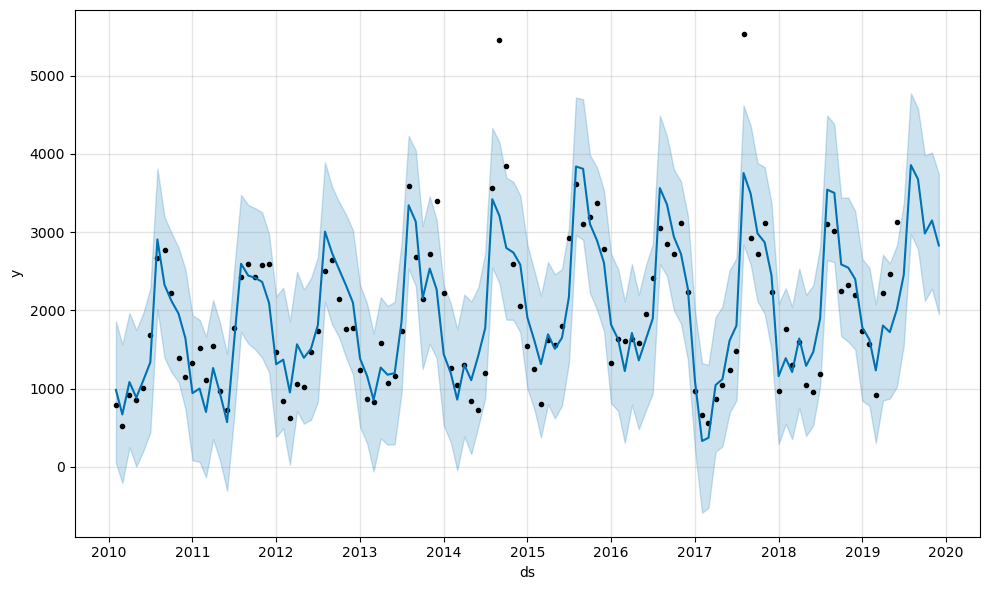

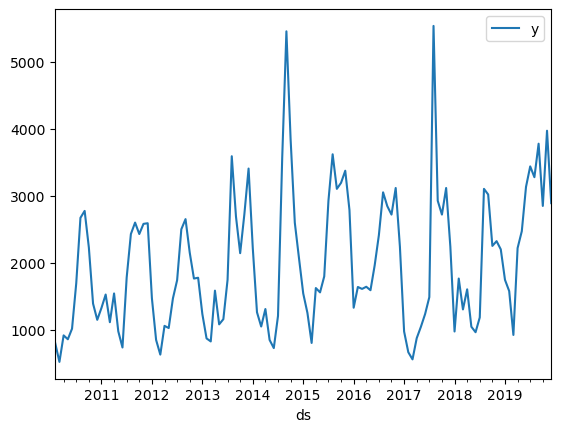

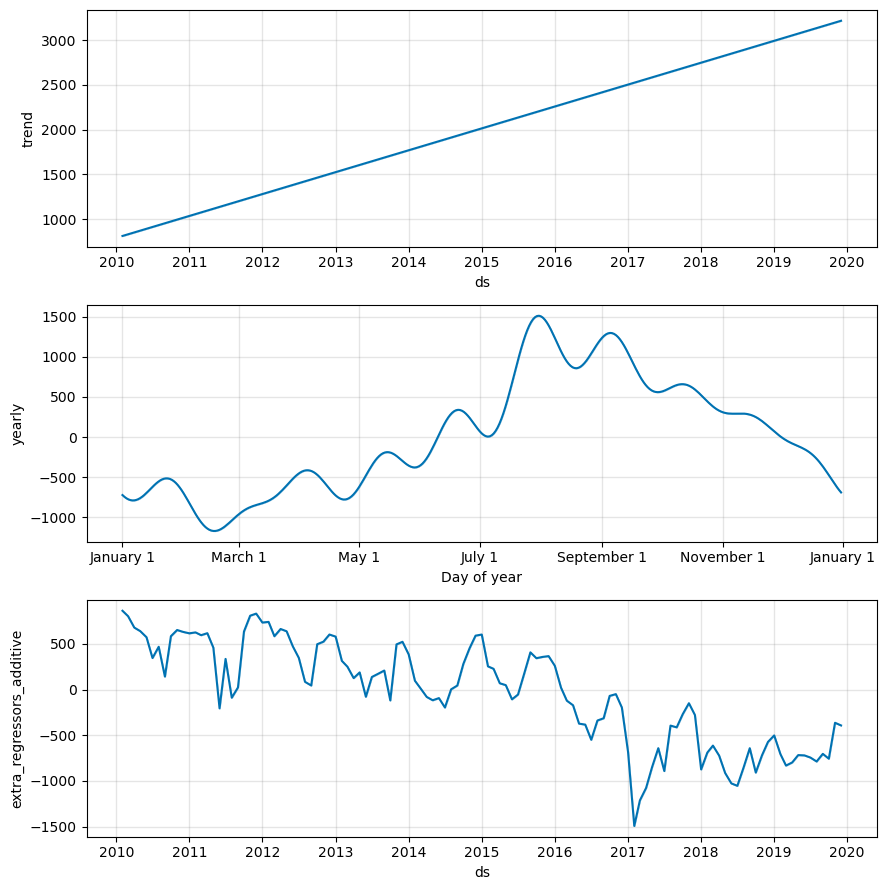

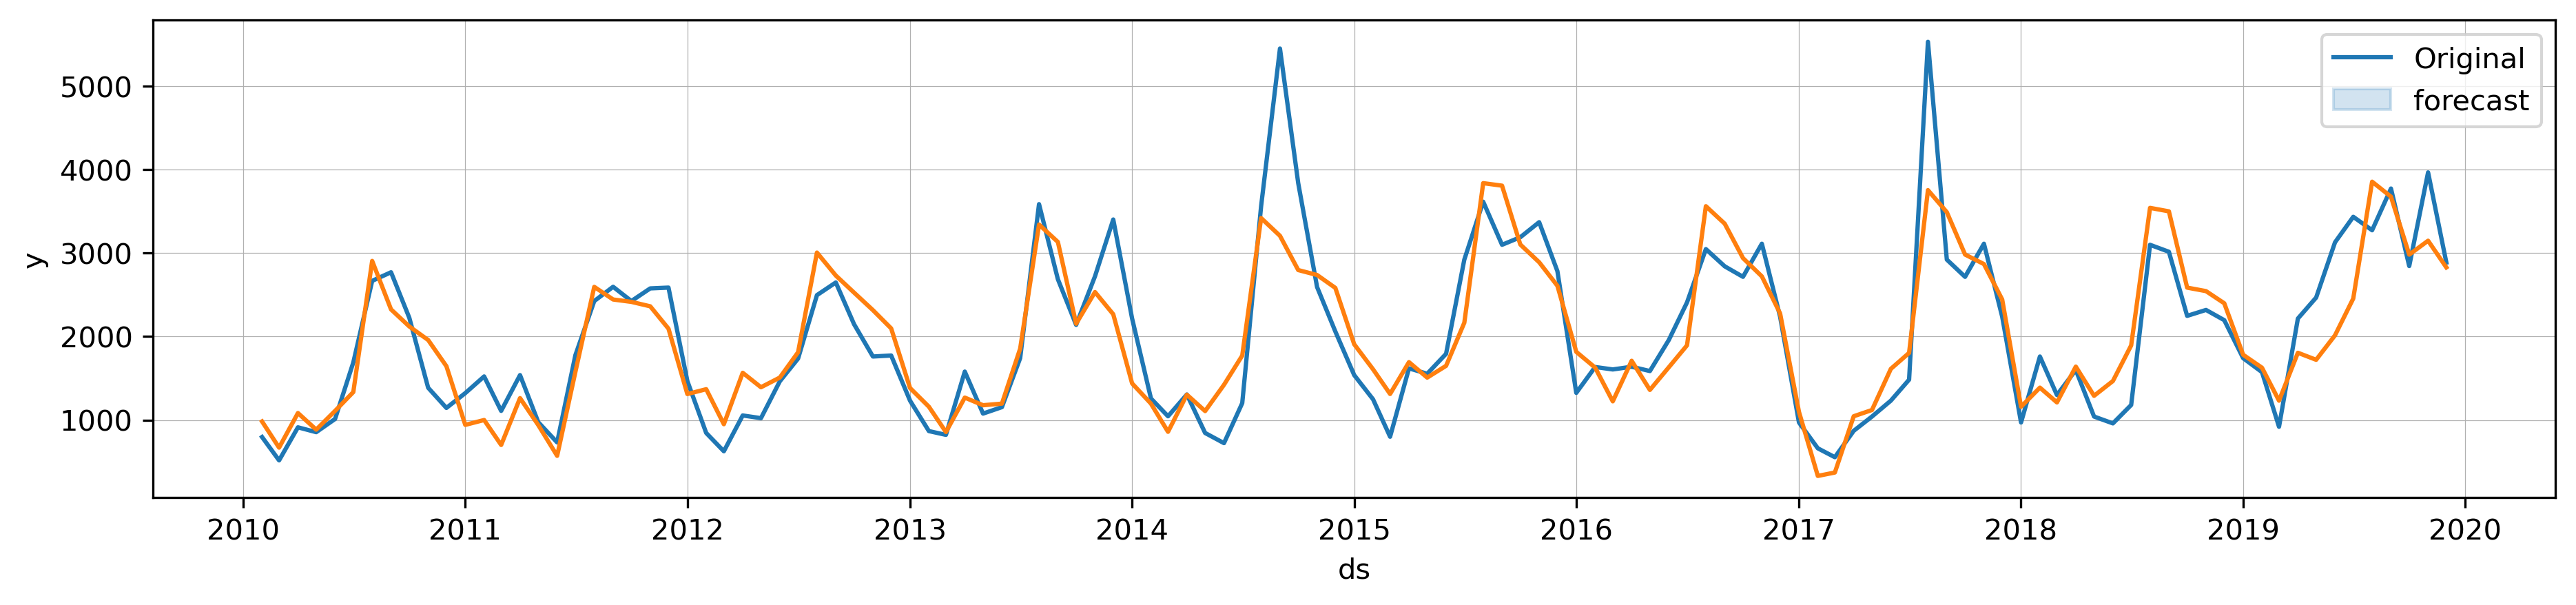

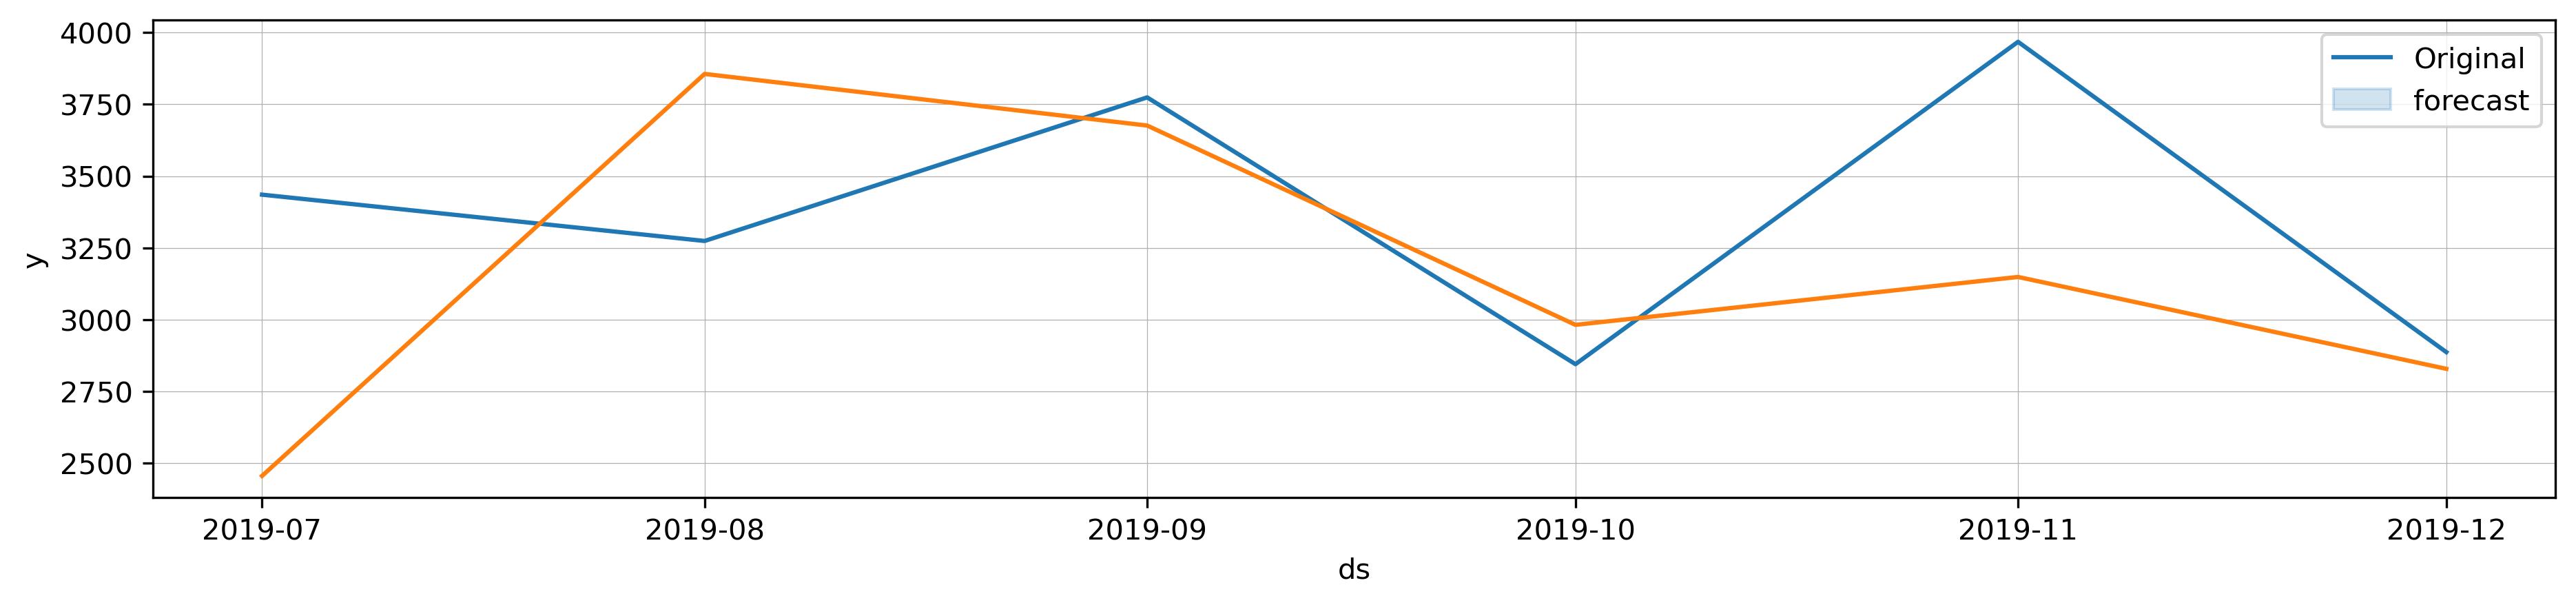

In [80]:
MAE_Prophet = model_prophet(finaldf)

# For arrival (mean attribute) 

05:01:01 - cmdstanpy - INFO - Chain [1] start processing
05:01:01 - cmdstanpy - INFO - Chain [1] done processing


Index(['Arrival Quantity_mean', 'y', 'NBS rate', 'dprice', 'Rainfall',
       'tasmax', 'GDP', 'ds'],
      dtype='object')
Prophetdf_test.shape[0]
6
            ds            y
113 2019-07-01  3435.483871
114 2019-08-01  3274.193548
115 2019-09-01  3774.193548
116 2019-10-01  2845.161290
117 2019-11-01  3967.741935
118 2019-12-01  2887.096774
future
            ds  Arrival Quantity_mean    NBS rate     dprice  Rainfall  \
0   2010-02-01              29.261111  133.582000  36.493899      14.8   
1   2010-03-01              27.405556  133.582000  36.493899       0.0   
2   2010-04-01              24.467742  133.582000  36.493899      15.4   
3   2010-05-01              22.201613  133.458833  36.493899      30.1   
4   2010-06-01              19.478495  133.335667  36.493899      66.6   
..         ...                    ...         ...        ...       ...   
114 2019-08-01              16.099462   90.651000  67.332319     201.6   
115 2019-09-01              12.733871   90.651000  66.2

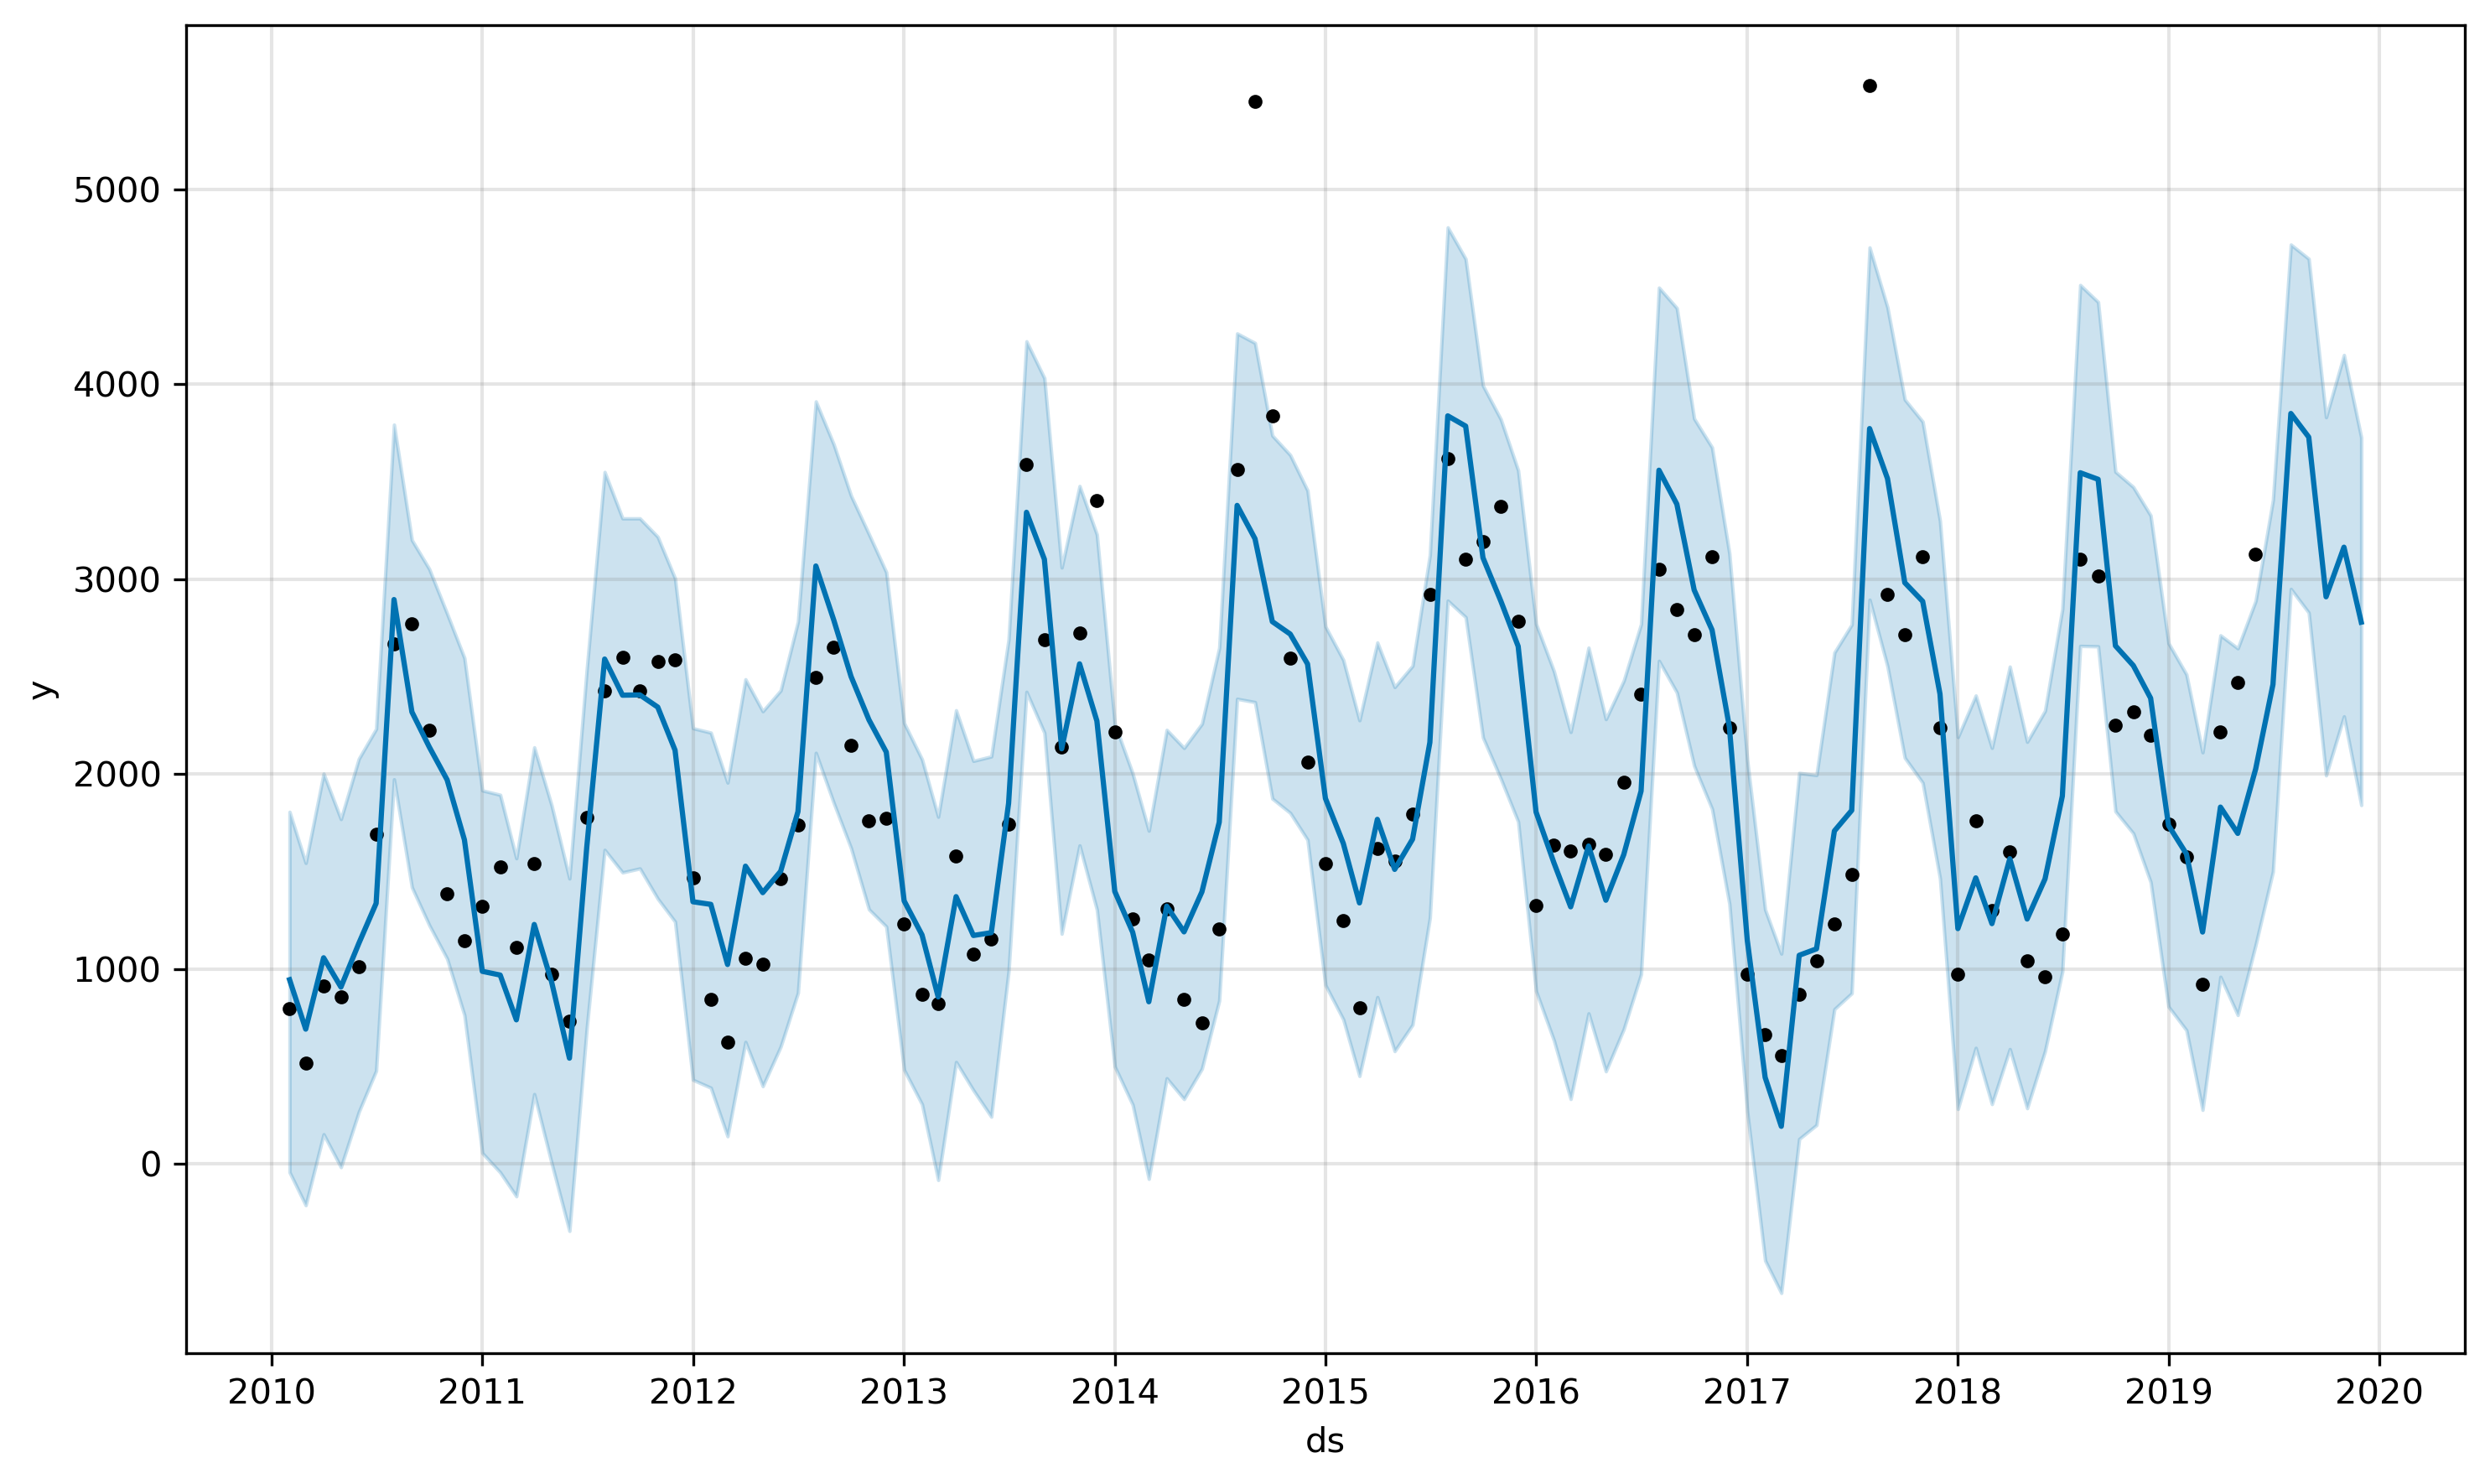

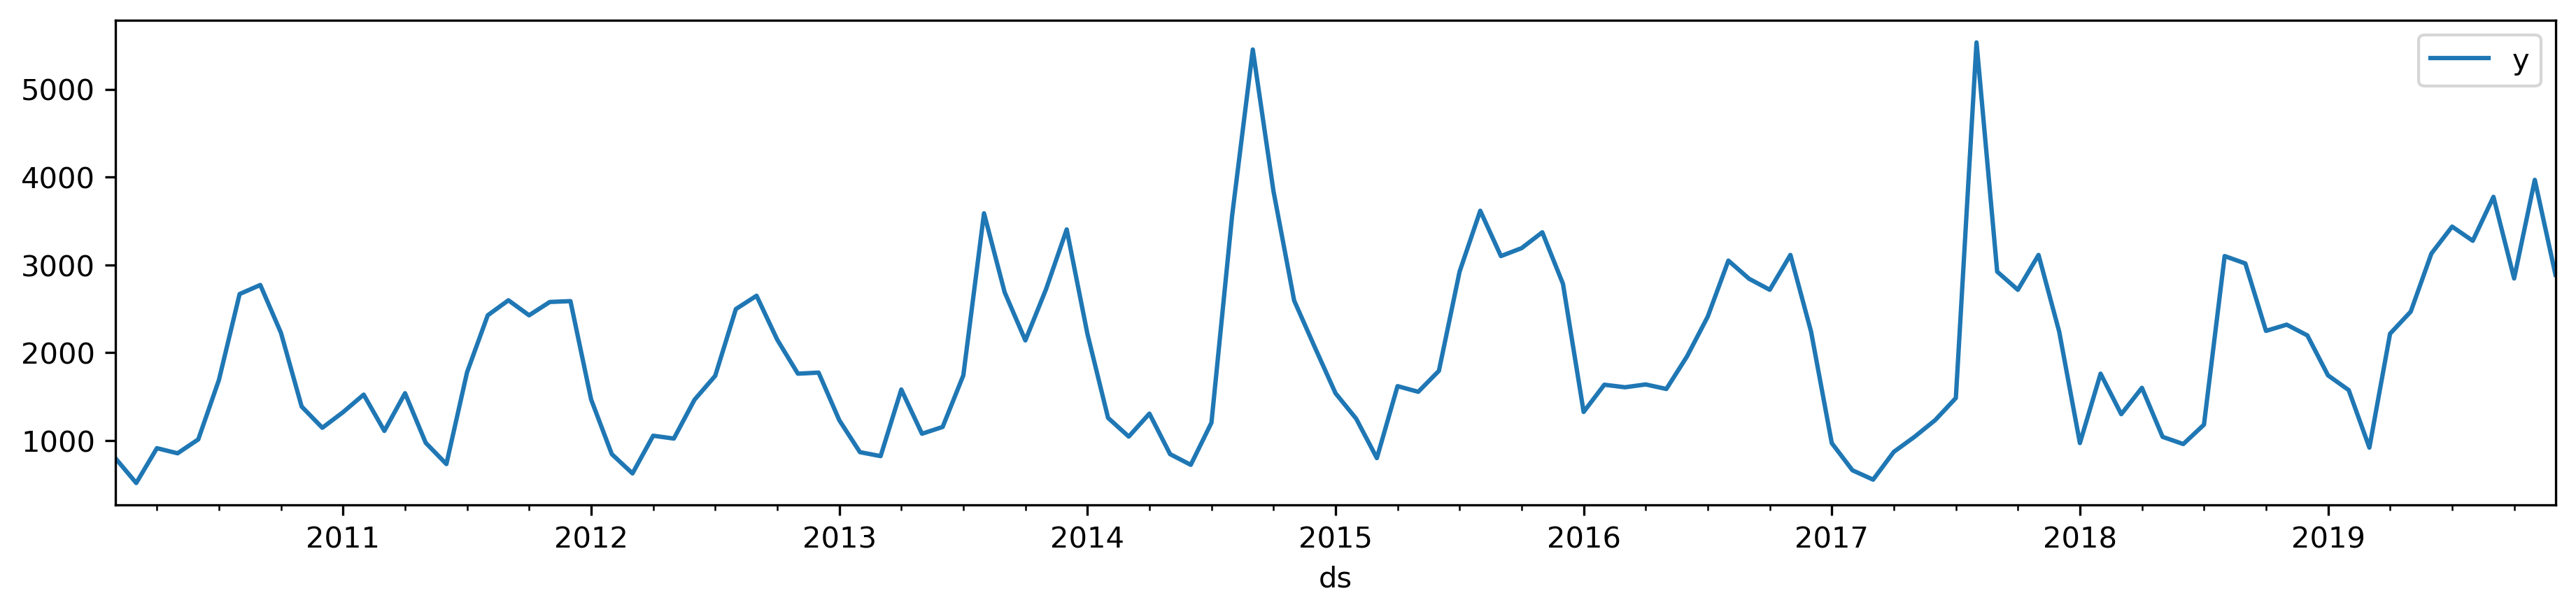

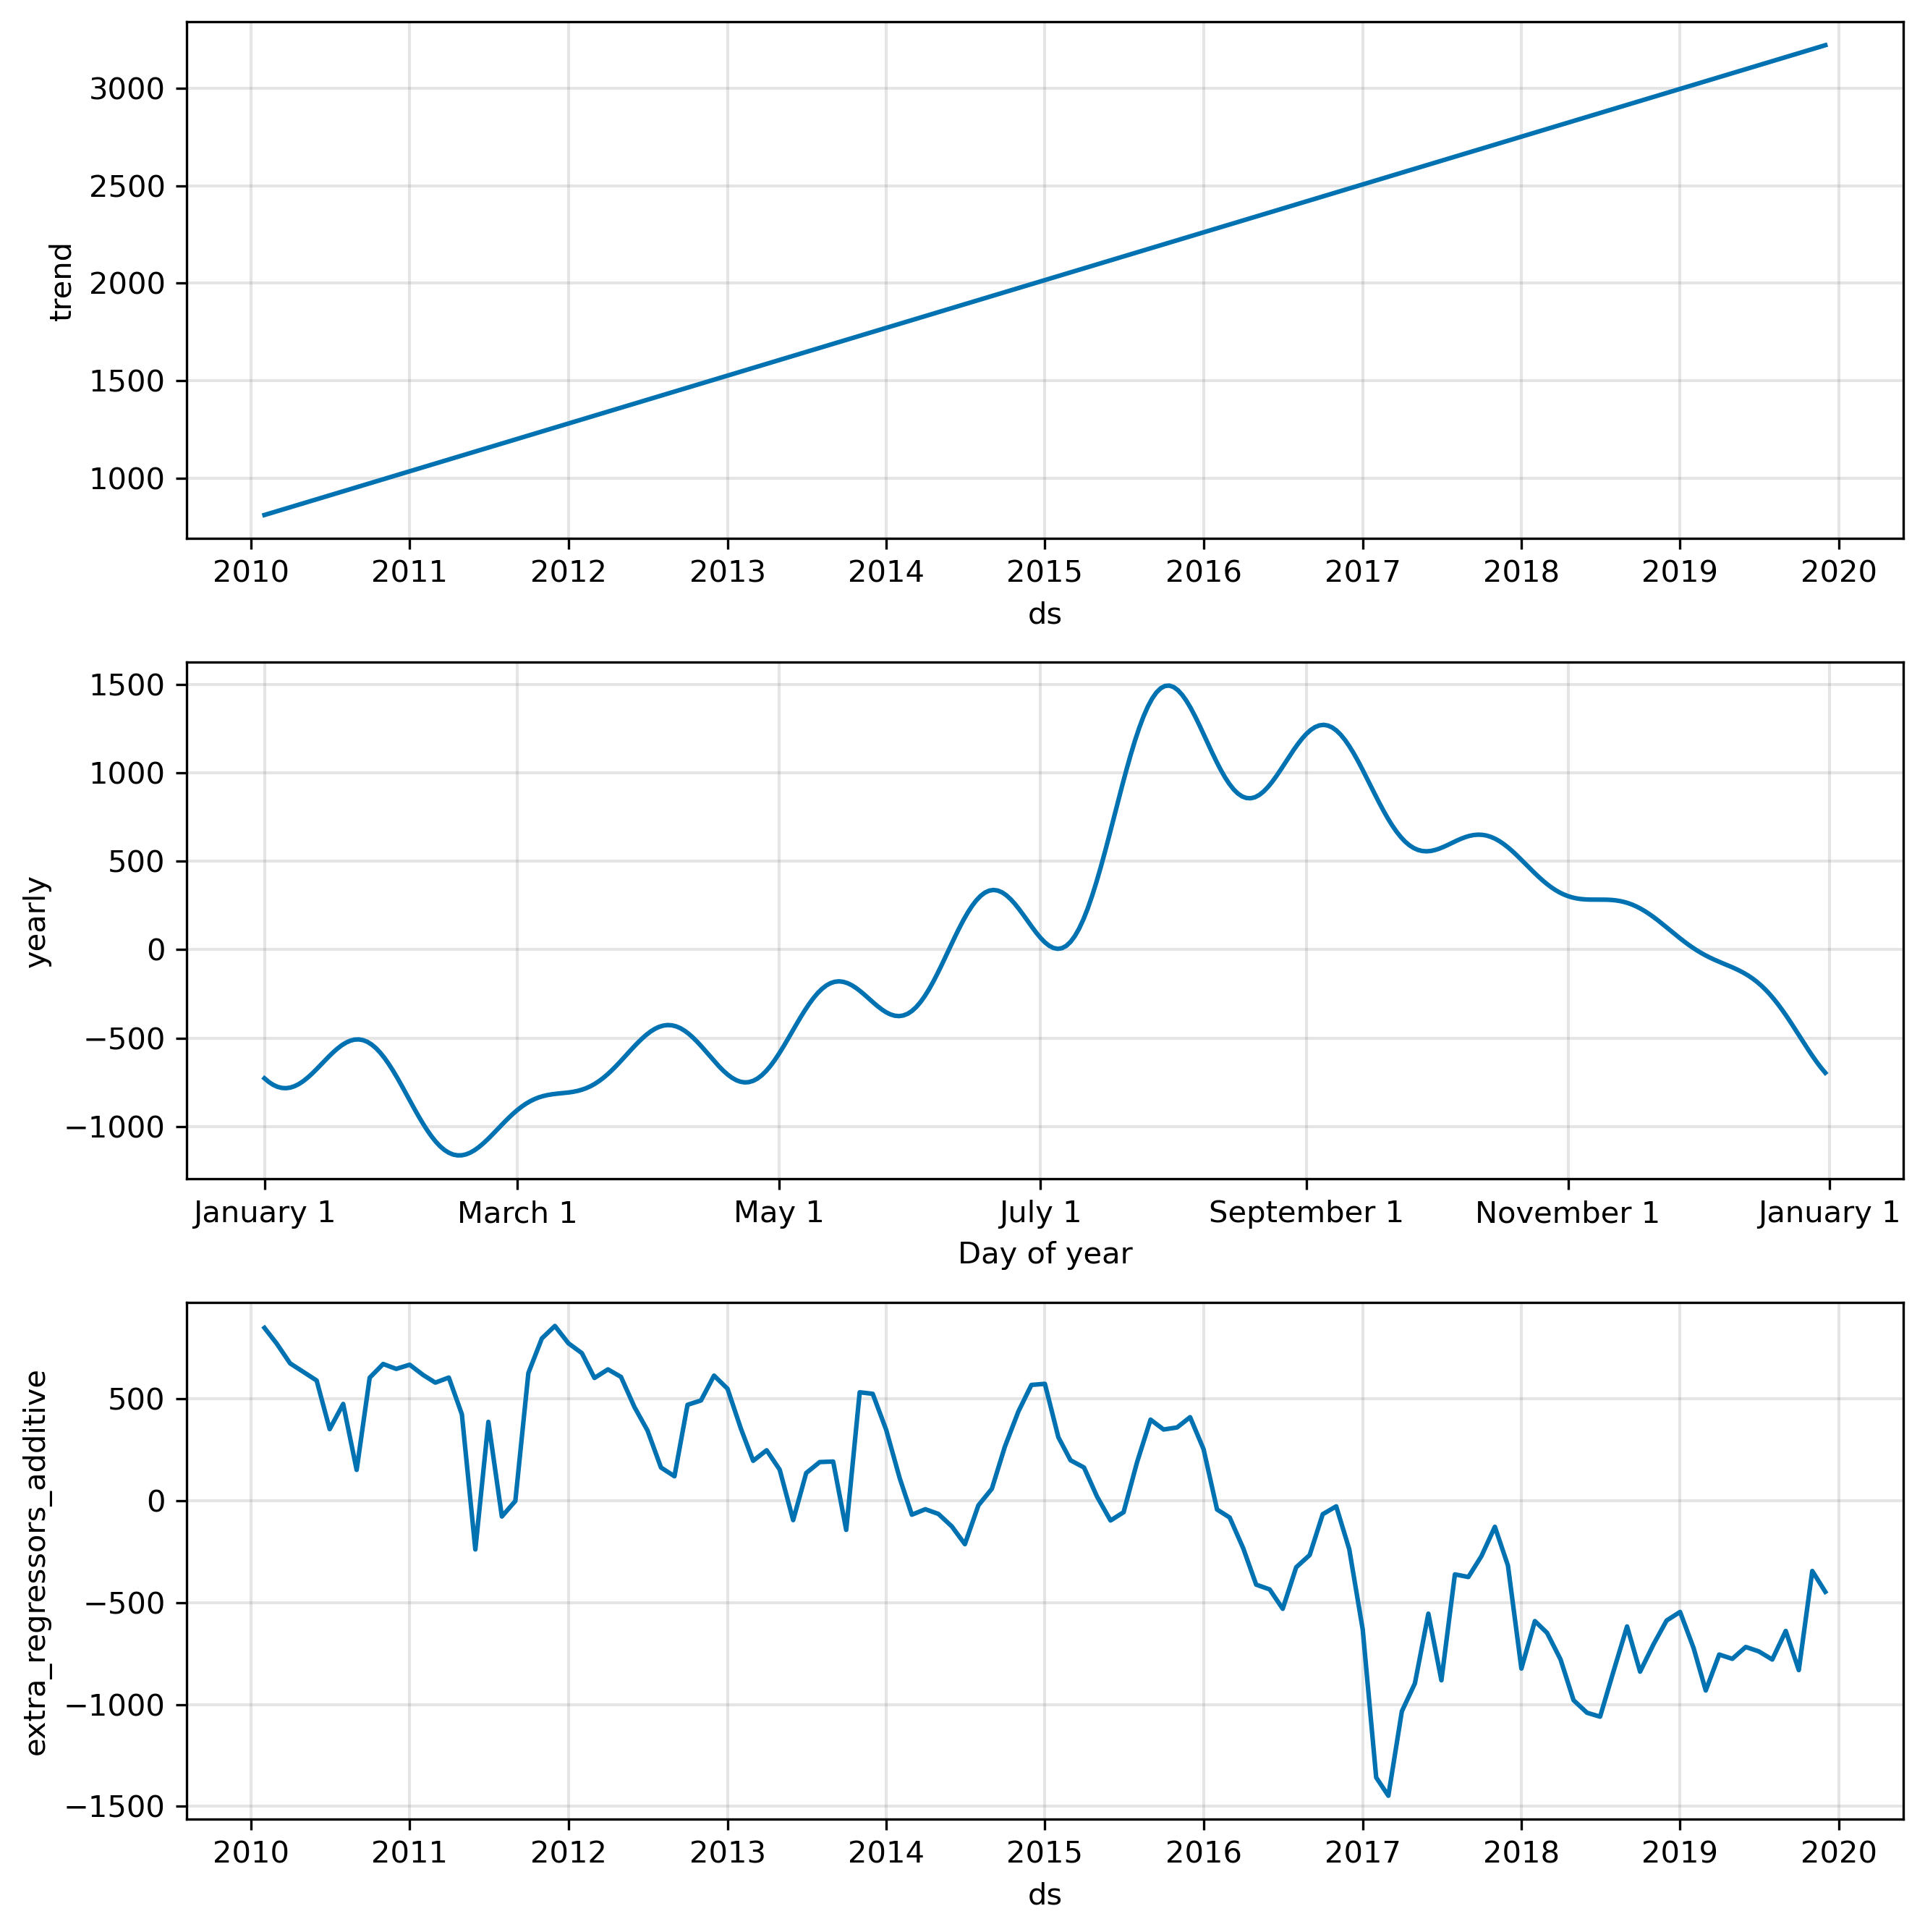

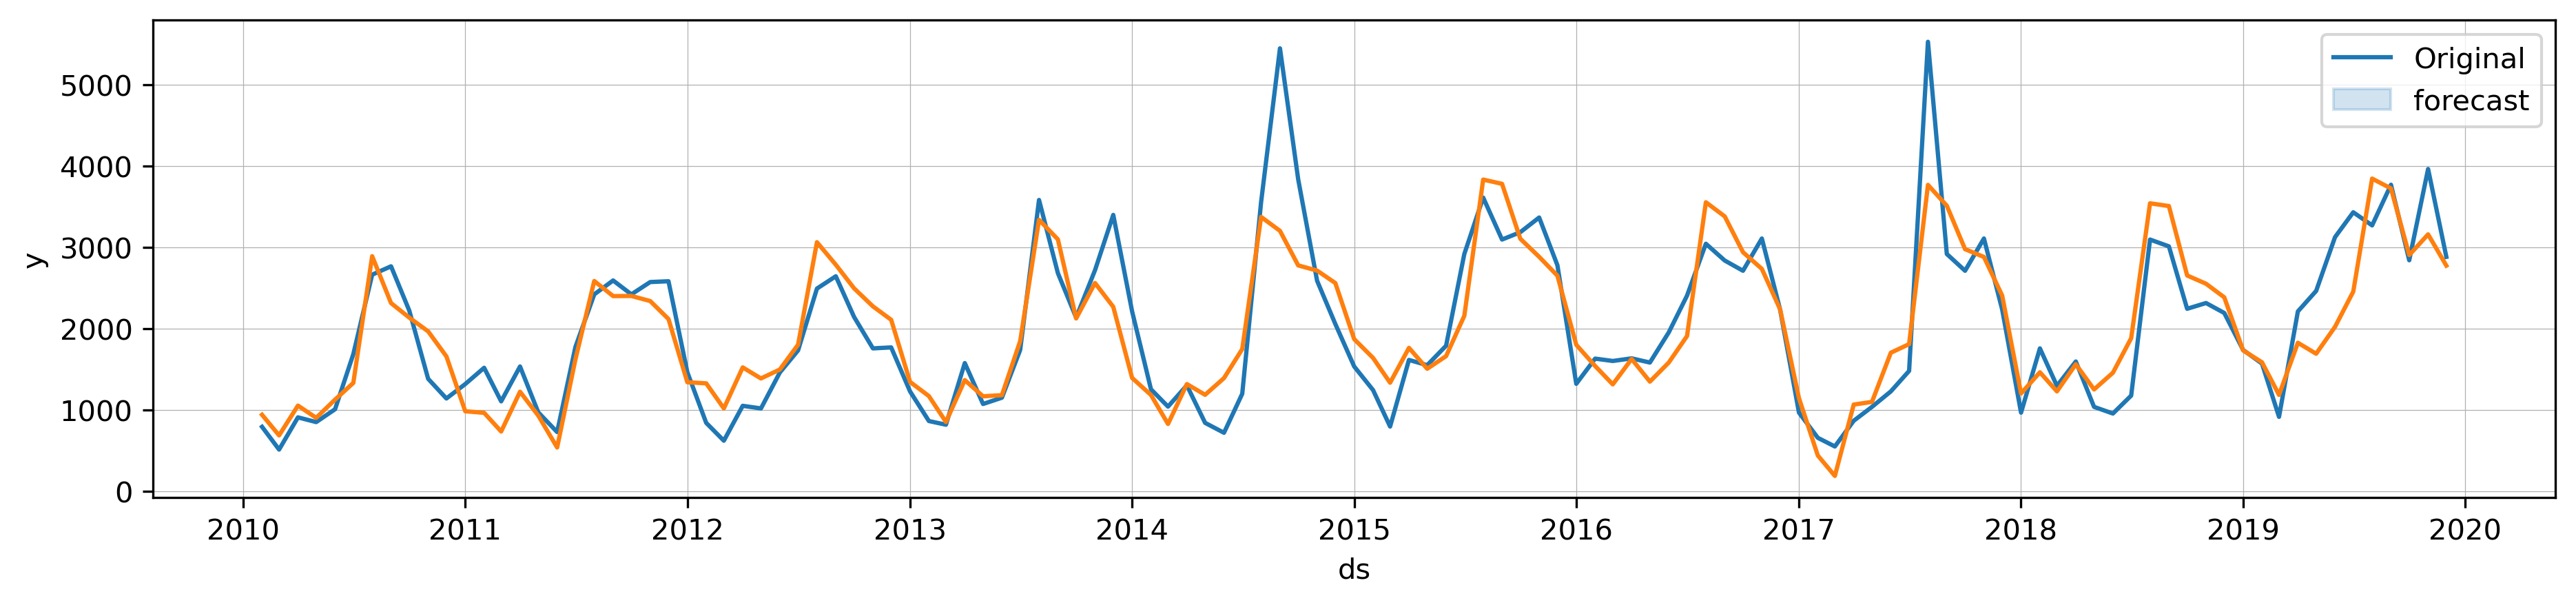

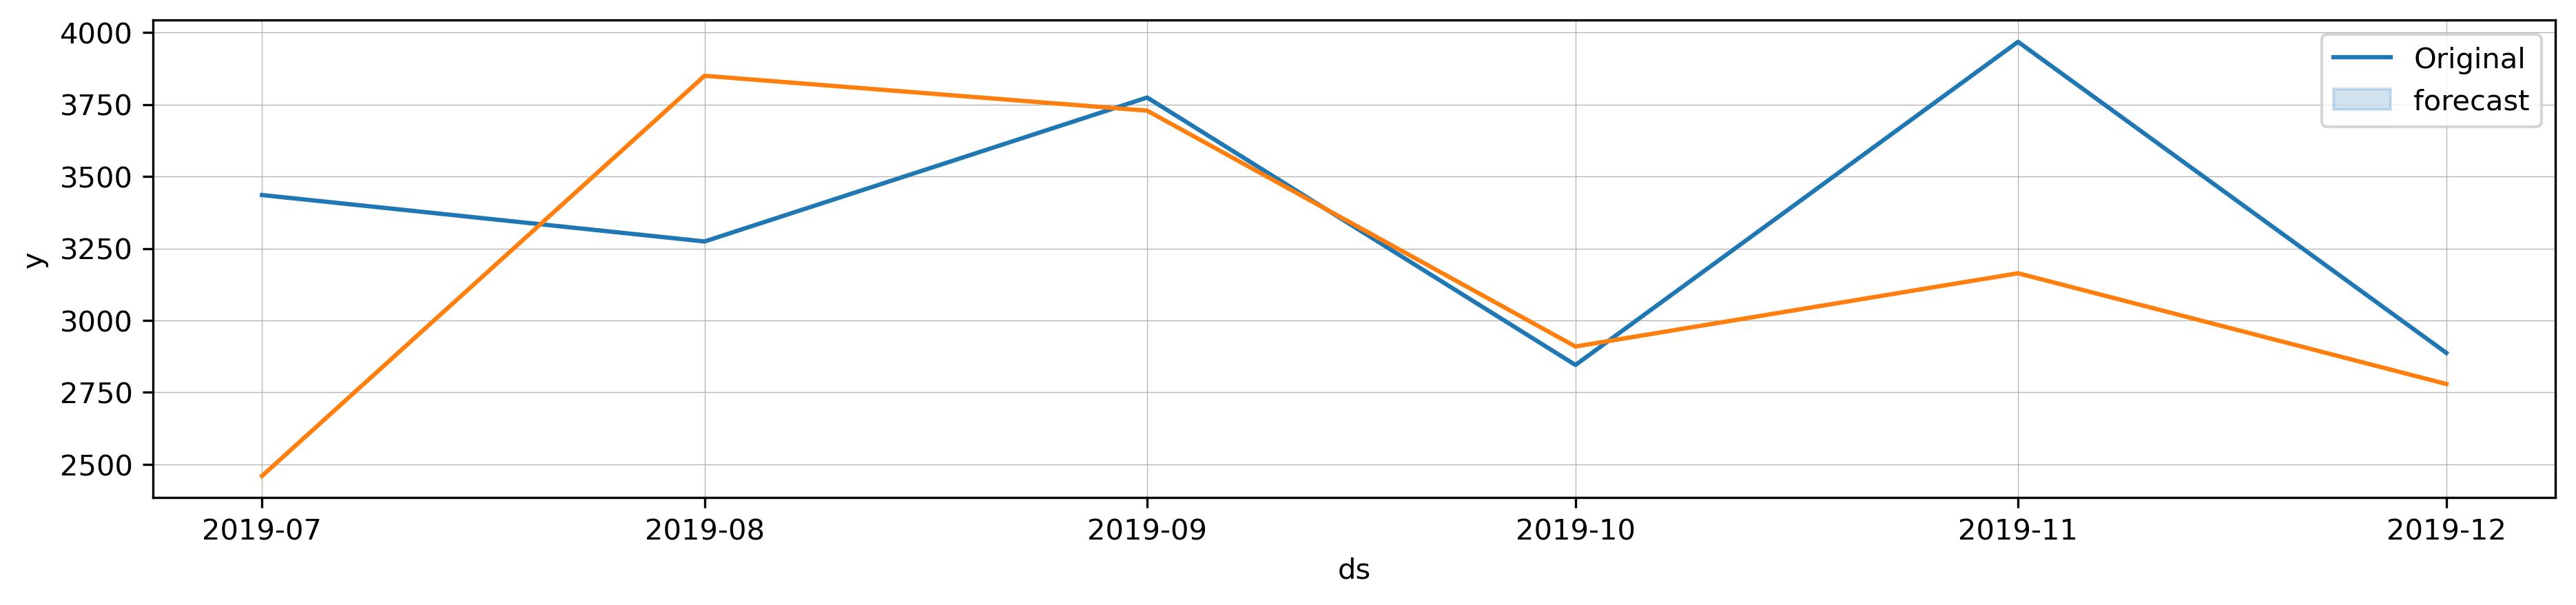

In [81]:
MAE_Prophet_1=model_prophet(finaldf1)